# Data mining competition #5

For the final challenge, there will be only one competition.

- Goal: predict the binary labels for the whole dataset.
- Metric: balanced accuracy.

## Competition rules


*You can only use unsupervised/self-supervised methods*. For 500 records, the labels are provided; you can use those for evaluating models, but not training. Apart from that, you can use any models and techniques that you see fit.
You can have up to three submissions, and the best of those will count for the final challenge. Your submissions *must have* the same format as comp_5_sample_submission.csv (containing either a 'yes' or 'no' in each column, in the order the dataset is originally given, without row numbers or headers), and it must have your name in the filename.

## Data description

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit.

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

## Attribute description

Bank client data:

    Age (numeric)
    Job : type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')
    Marital : marital status (categorical: 'divorced', 'married', 'single', 'unknown' ; note: 'divorced' means divorced or widowed)
    Education (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')
    Default: has credit in default? (categorical: 'no', 'yes', 'unknown')
    Housing: has housing loan? (categorical: 'no', 'yes', 'unknown')
    Loan: has personal loan? (categorical: 'no', 'yes', 'unknown')

Related with the last contact of the current campaign:

    Contact: contact communication type (categorical:
    'cellular','telephone')
    Month: last contact month of year (categorical: 'jan', 'feb', 'mar',
    …, 'nov', 'dec')
    Dayofweek: last contact day of the week (categorical:
    'mon','tue','wed','thu','fri')

Other attributes:

    Campaign: number of contacts performed during this campaign and for
    this client (numeric, includes last contact)
    Pdays: number of days that passed by after the client was last
    contacted from a previous campaign (numeric; 999 means client was not
    previously contacted)
    Previous: number of contacts performed before this campaign and for
    this client (numeric)
    Poutcome: outcome of the previous marketing campaign (categorical:
    'failure','nonexistent','success')

Social and economic context attributes

    Emp.var.rate: employment variation rate - quarterly indicator
    (numeric)
    Cons.price.idx: consumer price index - monthly indicator (numeric)
    Cons.conf.idx: consumer confidence index - monthly indicator
    (numeric)
    Euribor3m: euribor 3 month rate - daily indicator (numeric)
    Nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target): has the client subscribed a term deposit? (binary: 'yes', 'no')



# Setup

## Libraries

In [ ]:
!pip install sweetviz
#!pip install --upgrade pandas-profiling

In [ ]:
# foundation
import pandas as pd
import numpy as np
from numpy import nan
import matplotlib.pyplot as plt

# eda, pre-processing
import sweetviz as sv
from sklearn.preprocessing import LabelEncoder, StandardScaler

# modelling
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

# evaluation metric
from sklearn.metrics import balanced_accuracy_score

In [ ]:
# data importing
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/Portuguese banking telemarketing

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Portuguese banking telemarketing


In [ ]:
%ls

comp_5_data.csv       comp_5_lof.csv                rules.txt
comp_5_isoforest.csv  comp_5_oneclasssvm.csv        sweetviz_report_1.html
comp_5_kmeans.csv     comp_5_sample_submission.csv
comp_5_labels.csv     report_sweetviz_.html


## Load data

In [ ]:
# importing data
raw_data = pd.read_csv('comp_5_data.csv')
data = raw_data.copy()
data.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
25135,33,admin.,single,high.school,no,no,no,cellular,may,fri,9,999,1,failure,-1.8,92.893,-46.2,1.250,5099.1
17848,56,entrepreneur,married,university.degree,no,yes,no,cellular,nov,wed,2,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8
3311,43,admin.,divorced,high.school,no,no,no,telephone,may,fri,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
27341,62,management,divorced,high.school,no,no,no,cellular,aug,mon,1,999,0,nonexistent,-2.9,92.201,-31.4,0.861,5076.2
11016,33,technician,single,basic.9y,no,no,no,cellular,jul,thu,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30488 entries, 0 to 30487
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30488 non-null  int64  
 1   job             30488 non-null  object 
 2   marital         30488 non-null  object 
 3   education       30488 non-null  object 
 4   default         30488 non-null  object 
 5   housing         30488 non-null  object 
 6   loan            30488 non-null  object 
 7   contact         30488 non-null  object 
 8   month           30488 non-null  object 
 9   day_of_week     30488 non-null  object 
 10  campaign        30488 non-null  int64  
 11  pdays           30488 non-null  int64  
 12  previous        30488 non-null  int64  
 13  poutcome        30488 non-null  object 
 14  emp.var.rate    30488 non-null  float64
 15  cons.price.idx  30488 non-null  float64
 16  cons.conf.idx   30488 non-null  float64
 17  euribor3m       30488 non-null 

In [ ]:
# for 500 records, the labels are provided; you can use those for evaluating models, but not training.
labels = pd.read_csv('comp_5_labels.csv')
labels.columns = ['labels']
labels
print(labels.value_counts(), '\n\n',
      'Missing values:', '\n', labels.isna().sum().squeeze(), 'out of total', len(labels))
# keeping only observations with labels
labels = pd.concat([data, labels], axis=1).dropna(subset=['labels'])
# 1-0 encoding for the visualisation 
labels['labels'] = labels['labels'].map({'no': 0, 'yes': 1})
labels

labels
no        442
yes        58
dtype: int64 

 Missing values: 
 29987 out of total 30487


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,labels
22,56,technician,married,basic.4y,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
96,37,blue-collar,married,basic.9y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
253,43,self-employed,divorced,university.degree,no,no,no,telephone,may,tue,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
374,36,admin.,married,university.degree,no,yes,yes,telephone,may,tue,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
416,35,admin.,married,university.degree,no,yes,yes,telephone,may,tue,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29980,20,blue-collar,single,basic.4y,no,no,no,telephone,sep,mon,1,999,0,nonexistent,-1.1,94.199,-37.5,0.882,4963.6,1
30097,56,admin.,married,basic.9y,no,yes,yes,cellular,sep,thu,1,999,0,nonexistent,-1.1,94.199,-37.5,0.879,4963.6,1
30136,58,admin.,married,high.school,no,no,no,cellular,sep,thu,1,6,1,success,-1.1,94.199,-37.5,0.878,4963.6,1
30179,29,admin.,single,university.degree,no,no,no,cellular,sep,tue,2,3,3,success,-1.1,94.199,-37.5,0.880,4963.6,0


In [ ]:
# submissions must have the same format as comp_5_sample_submission.csv (containing either a 'yes' or 'no' in each column, in the order the dataset is originally given, without row numbers or headers), and it must have your name in the filename
sample_submission = pd.read_csv('comp_5_sample_submission.csv', header=None)
sample_submission.columns = ['sample']
sample_submission.value_counts()

sample
no        27448
yes        3040
dtype: int64

In [ ]:
sample_submission.sample(5)

,sample
27747,yes
25742,no
25423,no
27362,no
18834,no


In [ ]:
# evaluating the example submission against the given evaluation labels
sample_df = pd.merge(left=labels, right=sample_submission, left_index=True, right_index=True, how='left')
sample_df['sample'] = sample_df['sample'].map({'yes': 1, 'no': 0})
print(balanced_accuracy_score(y_true=sample_df['labels'], y_pred=sample_df['sample']))
sample_df

0.5139647370884693


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,labels,sample
22,56,technician,married,basic.4y,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1
96,37,blue-collar,married,basic.9y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
253,43,self-employed,divorced,university.degree,no,no,no,telephone,may,tue,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
374,36,admin.,married,university.degree,no,yes,yes,telephone,may,tue,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
416,35,admin.,married,university.degree,no,yes,yes,telephone,may,tue,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29980,20,blue-collar,single,basic.4y,no,no,no,telephone,sep,mon,...,999,0,nonexistent,-1.1,94.199,-37.5,0.882,4963.6,1,0
30097,56,admin.,married,basic.9y,no,yes,yes,cellular,sep,thu,...,999,0,nonexistent,-1.1,94.199,-37.5,0.879,4963.6,1,0
30136,58,admin.,married,high.school,no,no,no,cellular,sep,thu,...,6,1,success,-1.1,94.199,-37.5,0.878,4963.6,1,0
30179,29,admin.,single,university.degree,no,no,no,cellular,sep,tue,...,3,3,success,-1.1,94.199,-37.5,0.880,4963.6,0,0


# Exploratory data analysis

## Unlabeled dataset

Learning to perform exploratory data analysis is I believe an essential skill in an aspiring data scientists toolkit. However, after doing more and more by hand the process may become tiring. For this reason I was looking for automated ways of performing EDA and [found](https://medium.com/analytics-vidhya/automated-eda-using-pandas-profiling-sweetviz-autoviz-4f15c4031a12) several implementations that serves exactly this demand.

My strategy is the following: perform EDA using `sweetviz`, make a note of interesting findings and identify key takeaways that may require further manual analysis, apply neccessary transformations and iterate.

                                             |          | [  0%]   00:00 -> (? left)


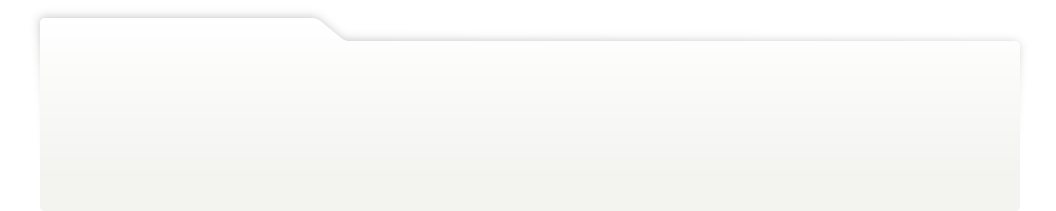
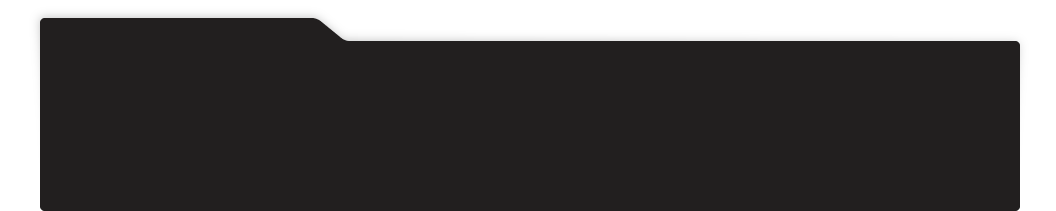
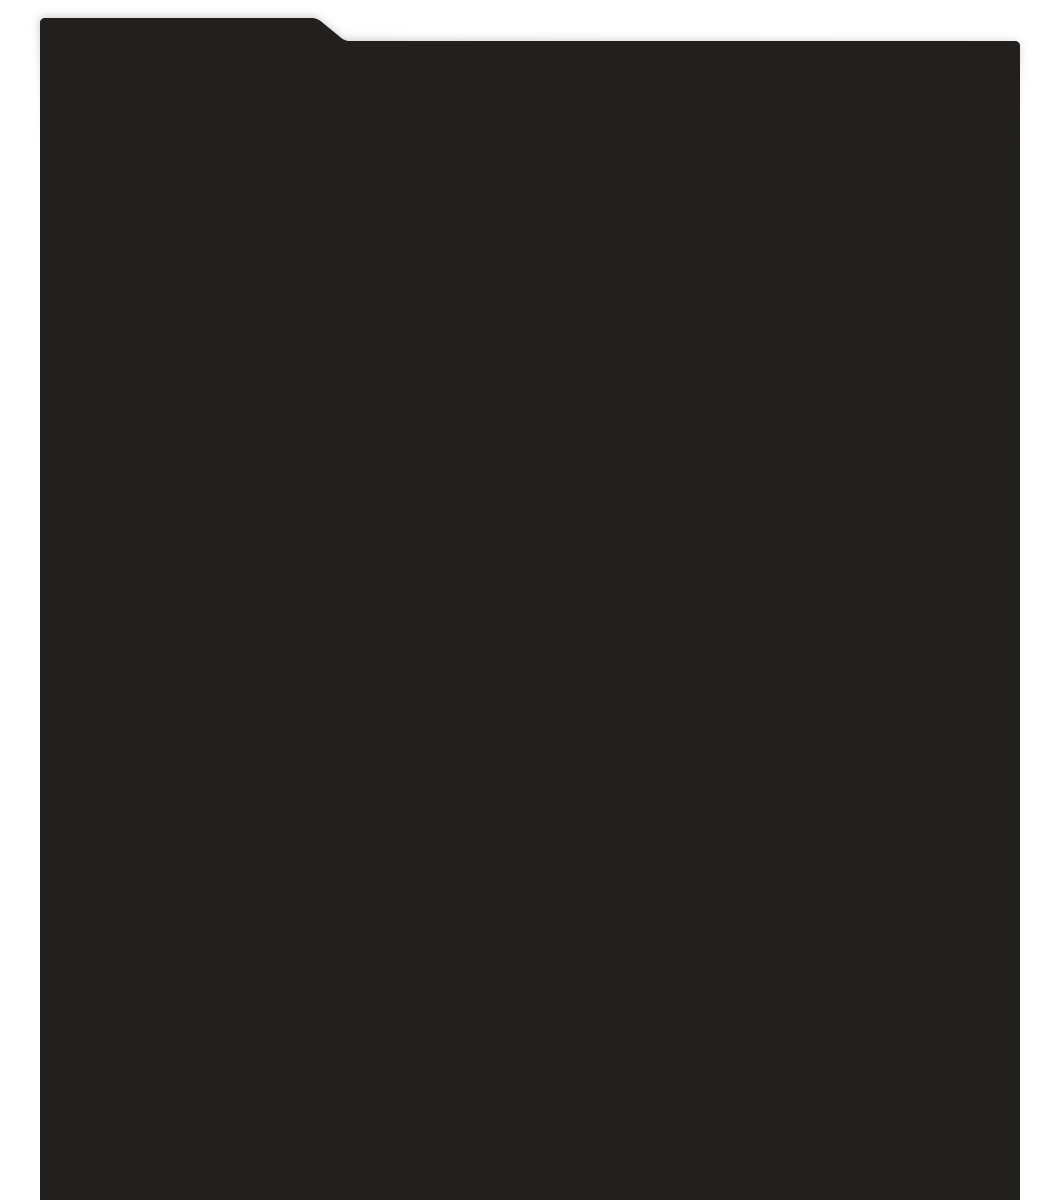
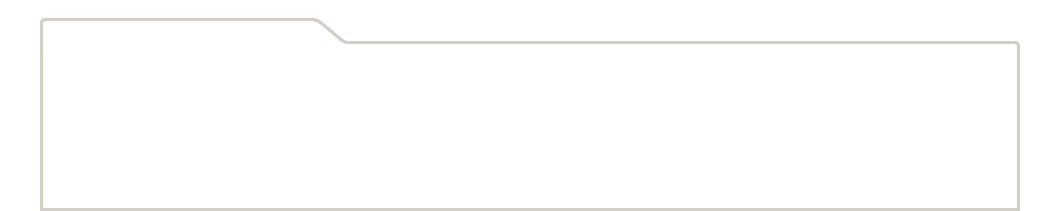
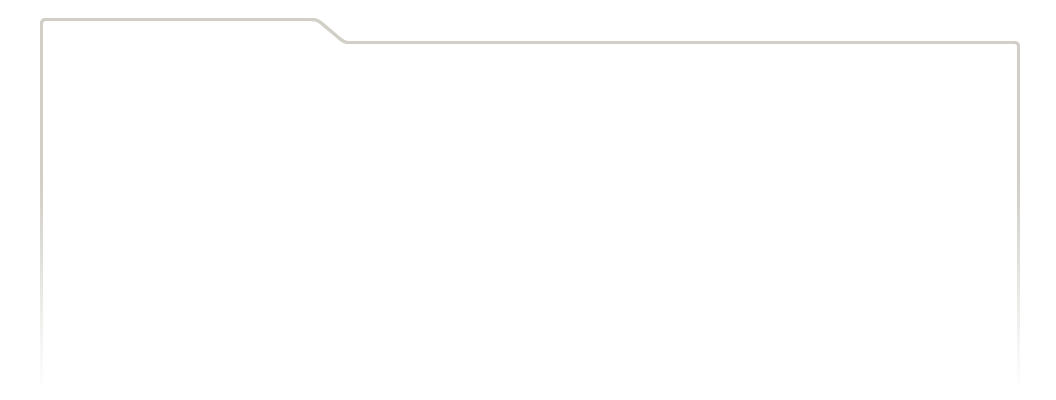
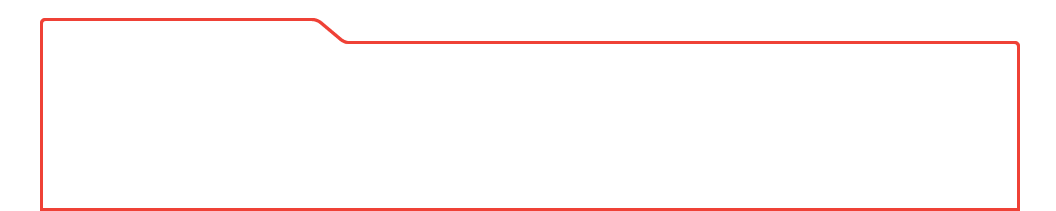
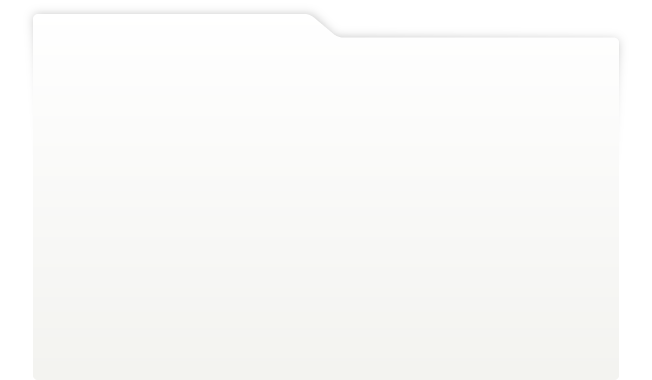
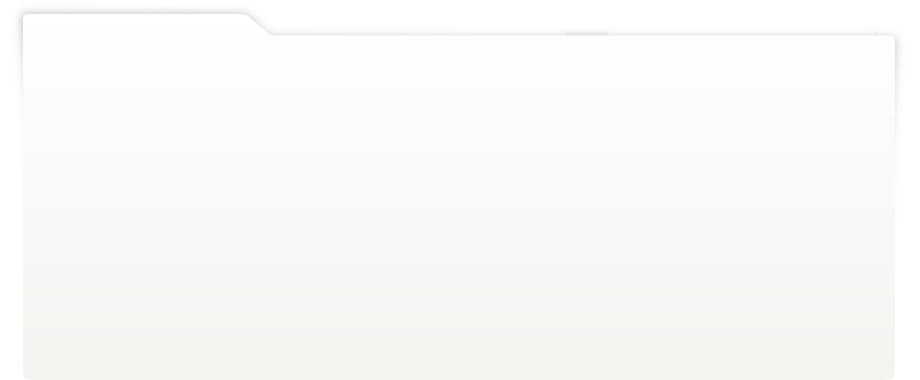
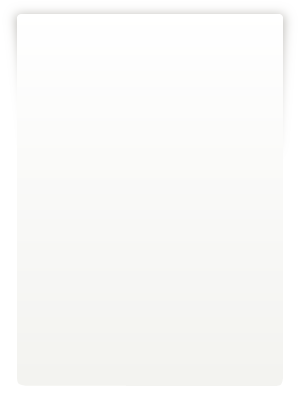
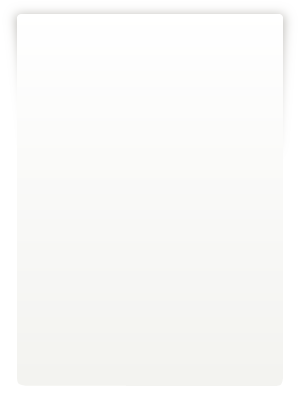
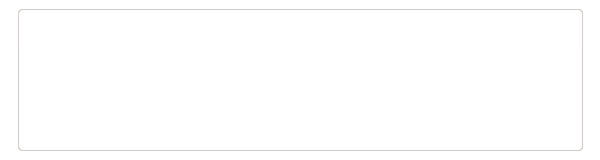
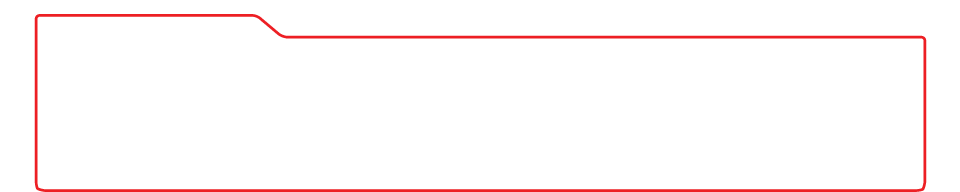
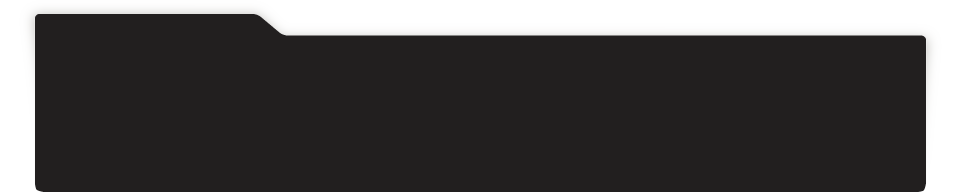
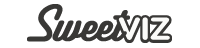
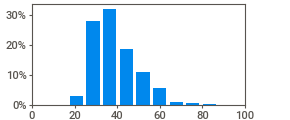
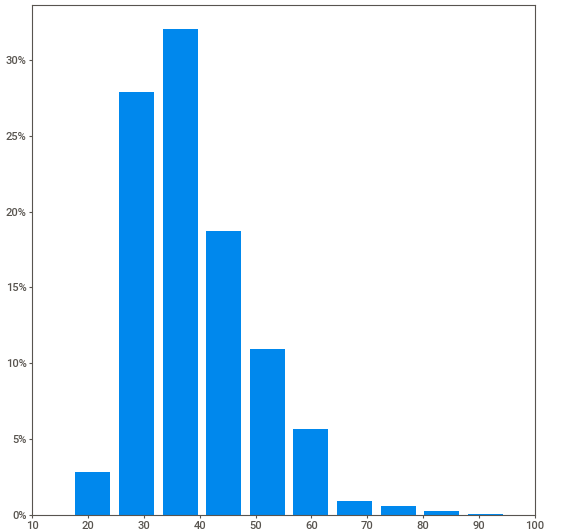
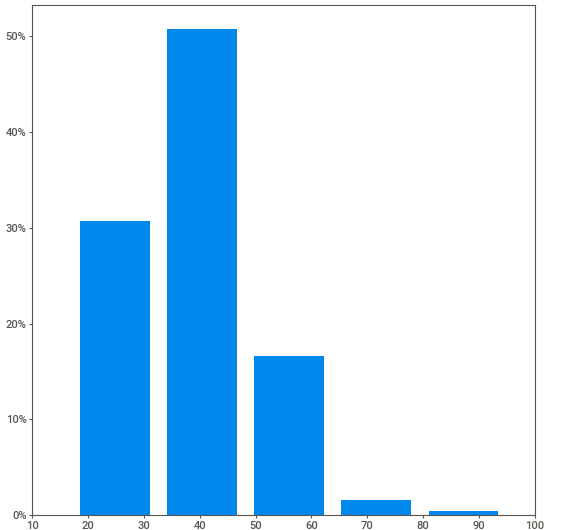
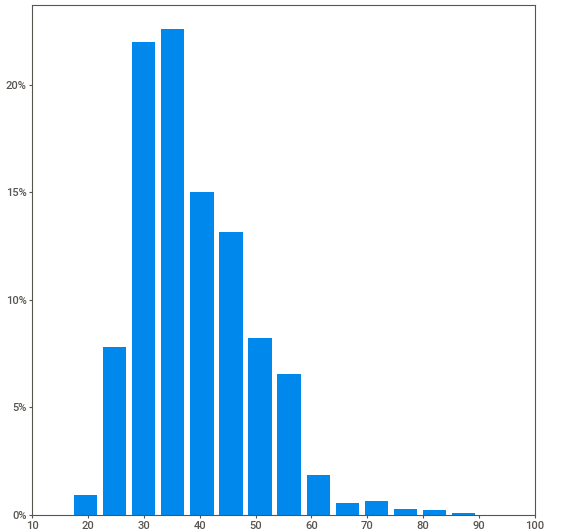
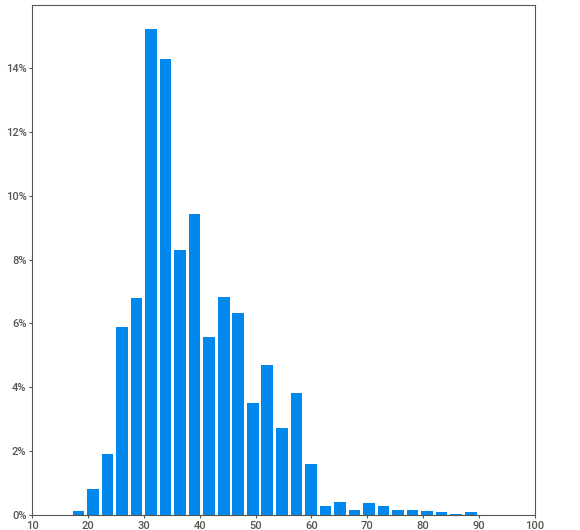
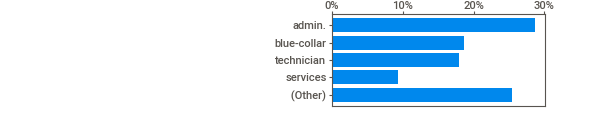
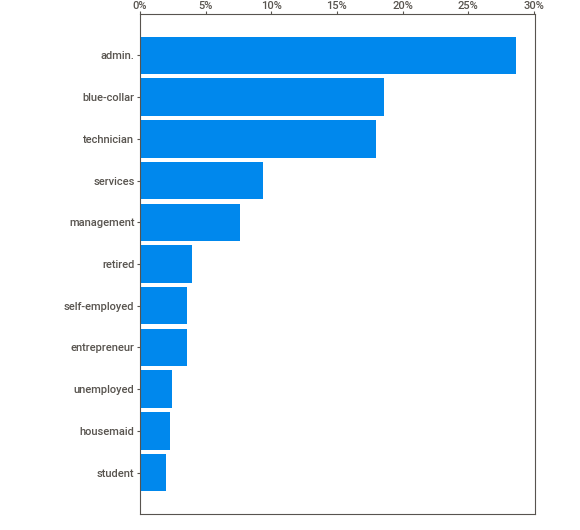
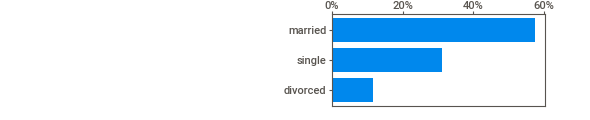
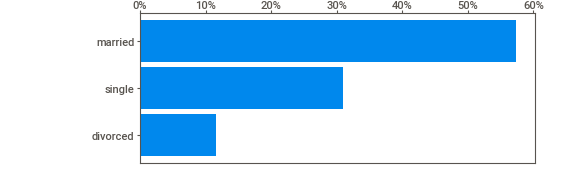
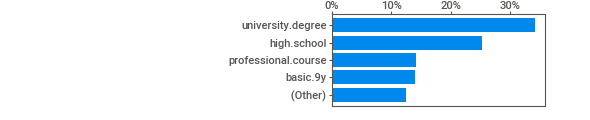
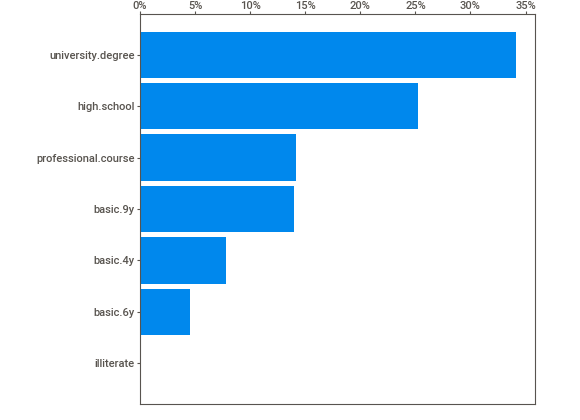
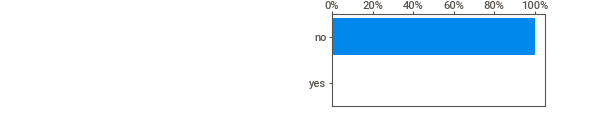
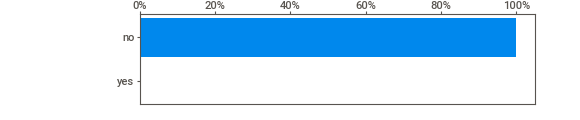
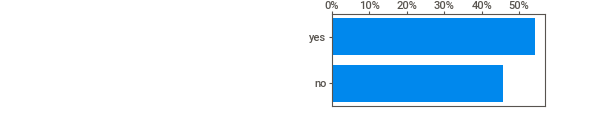
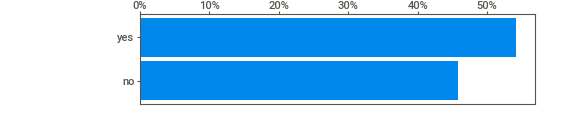
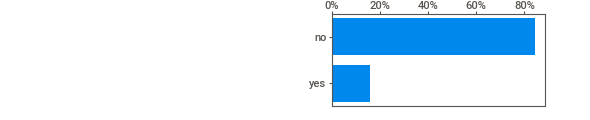
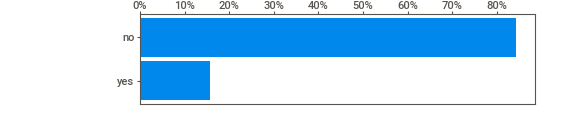
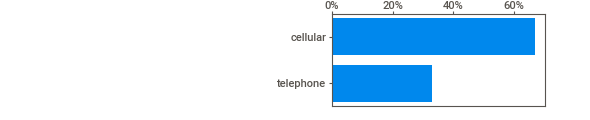
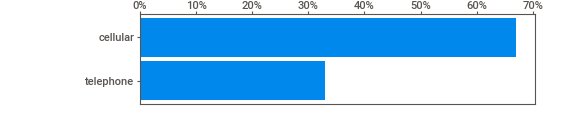
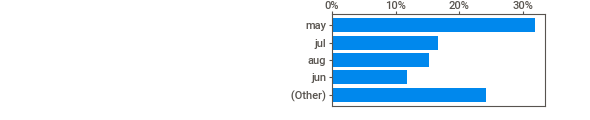
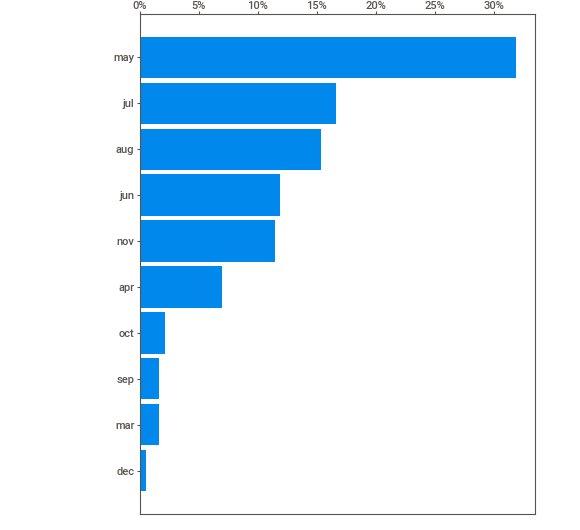
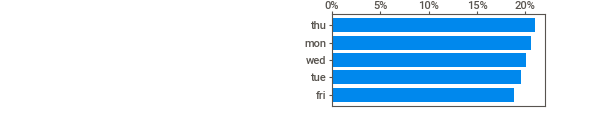
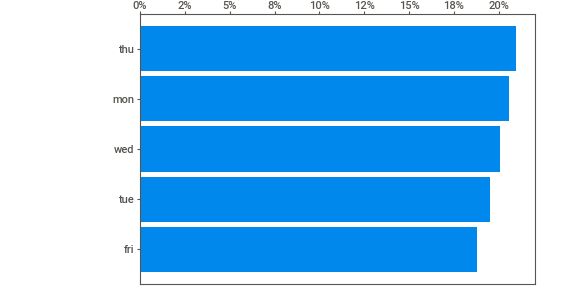
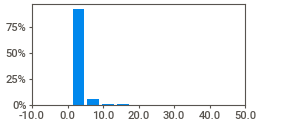
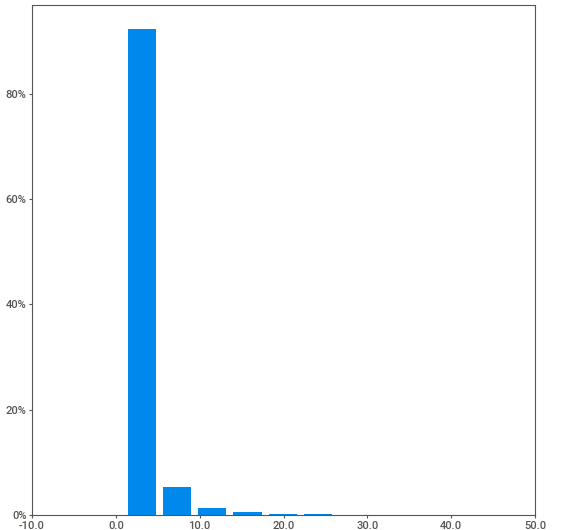
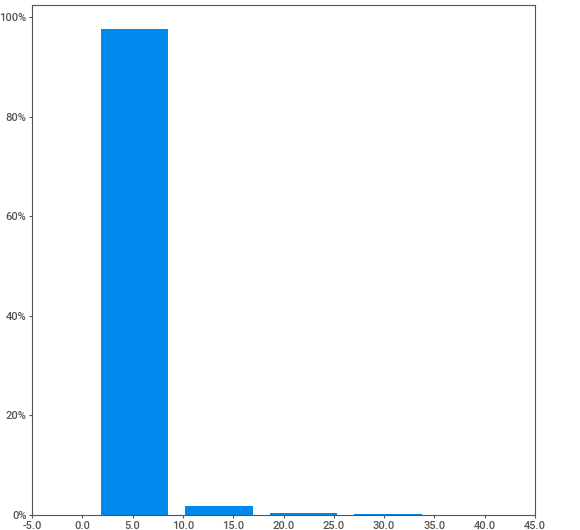
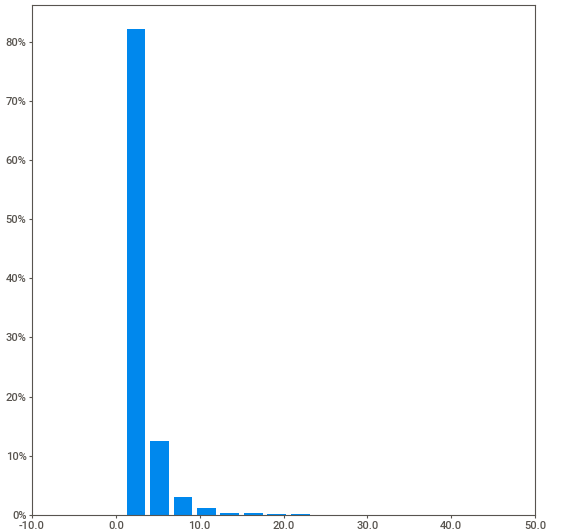
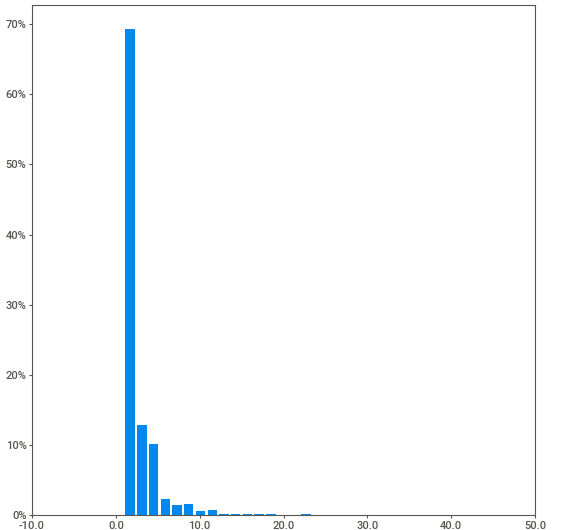
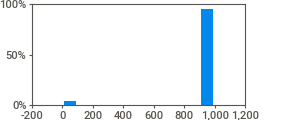
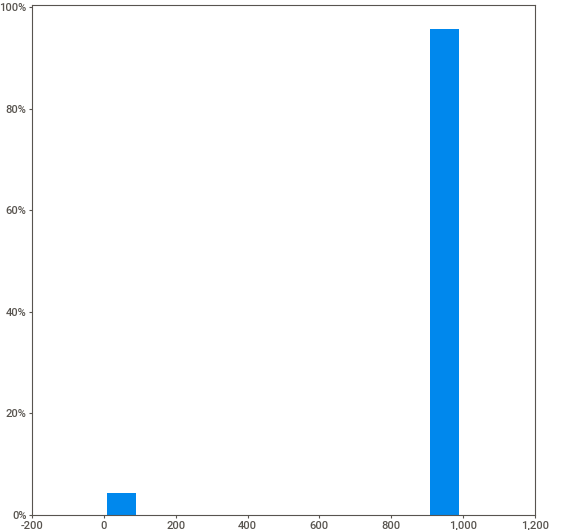
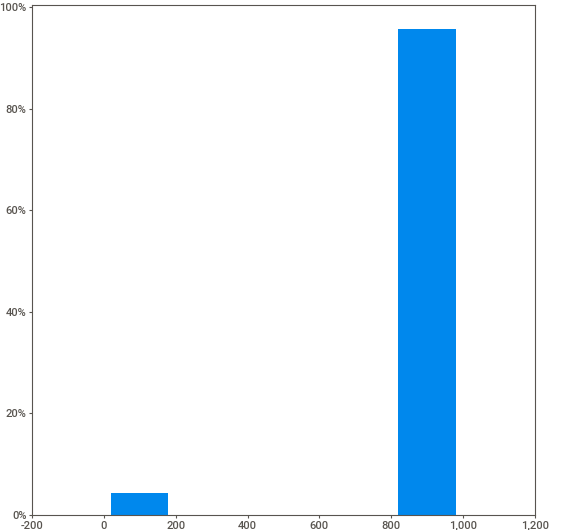
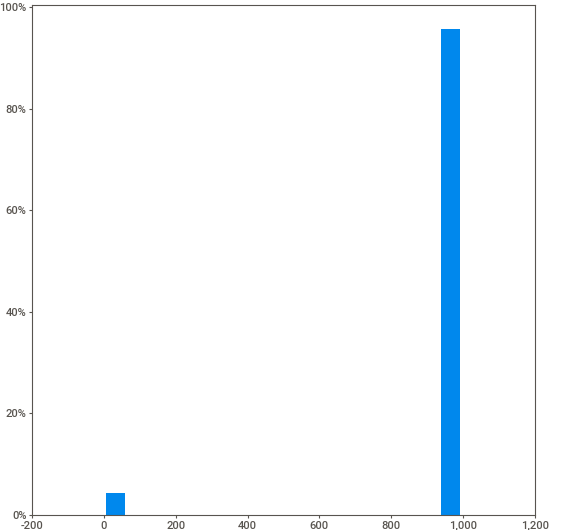
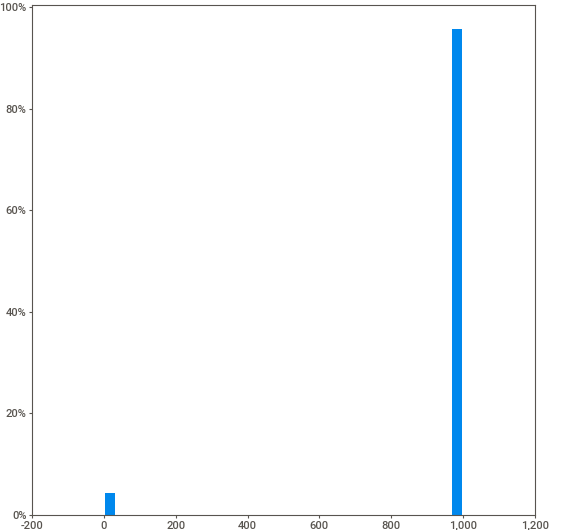
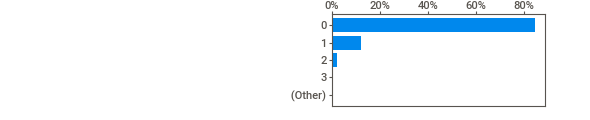
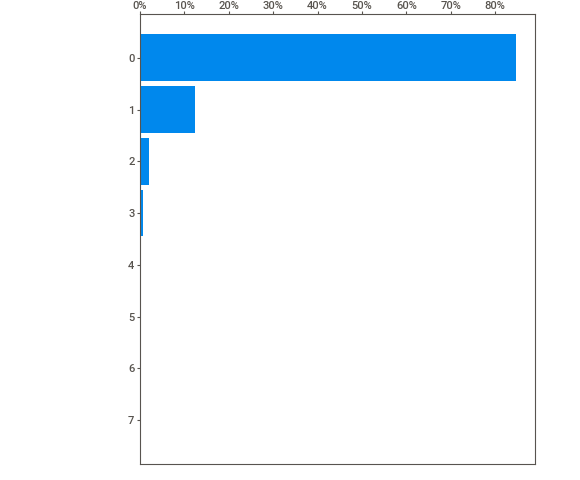
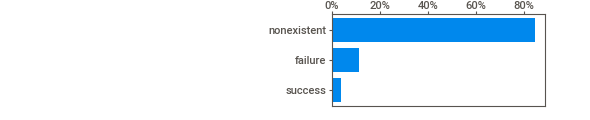
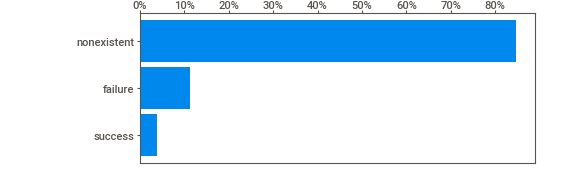
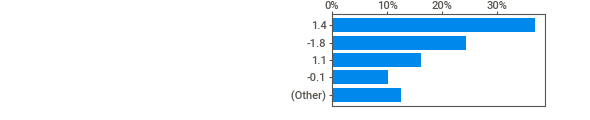
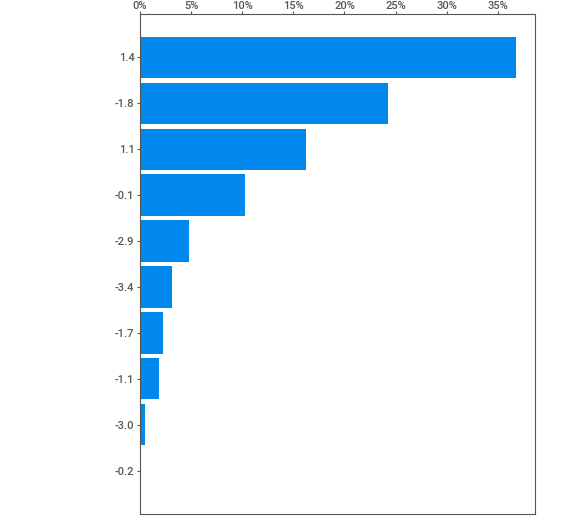
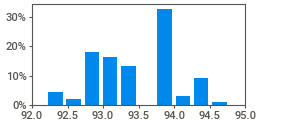
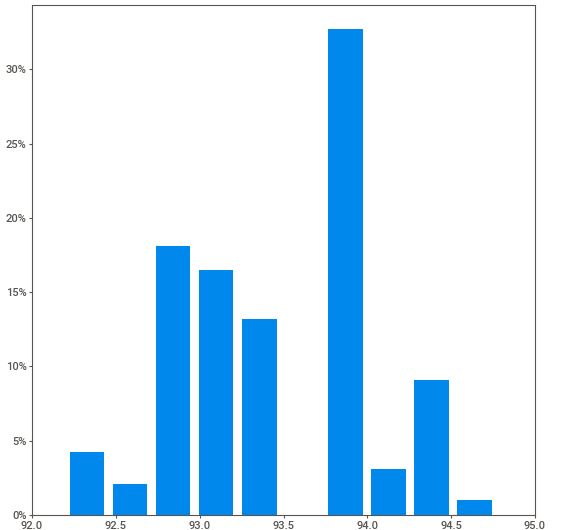
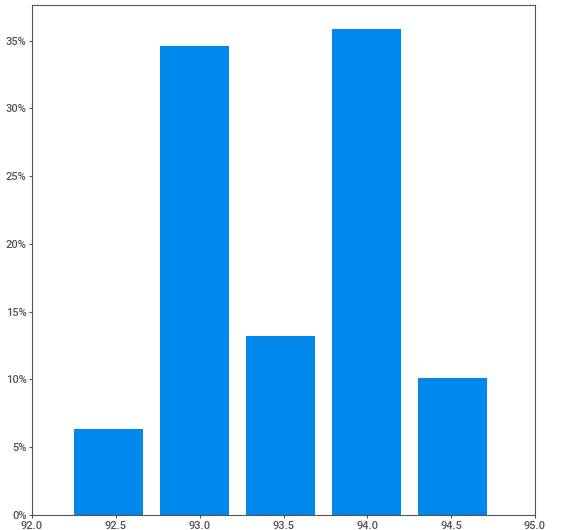
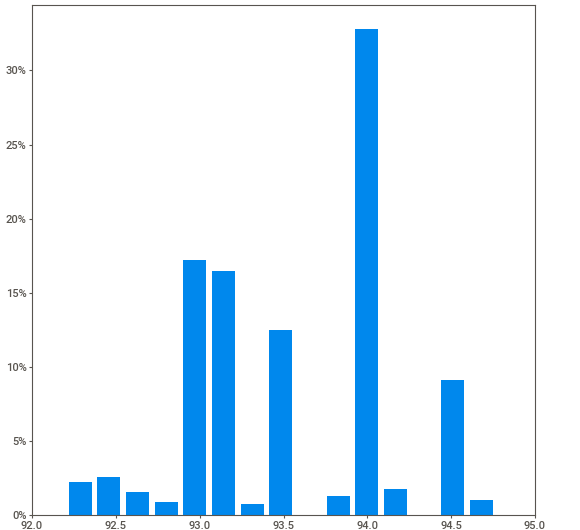
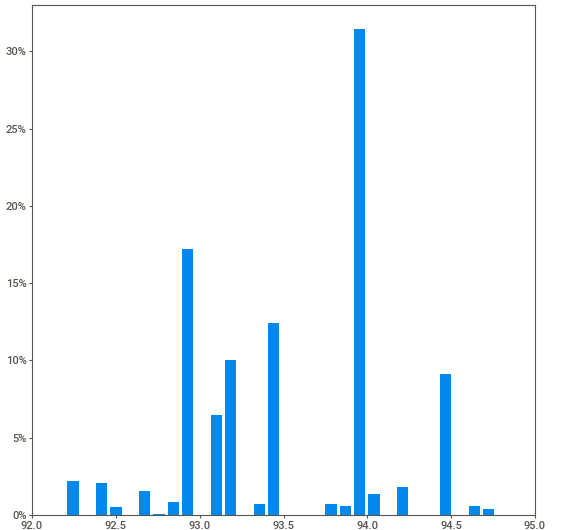
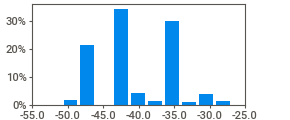
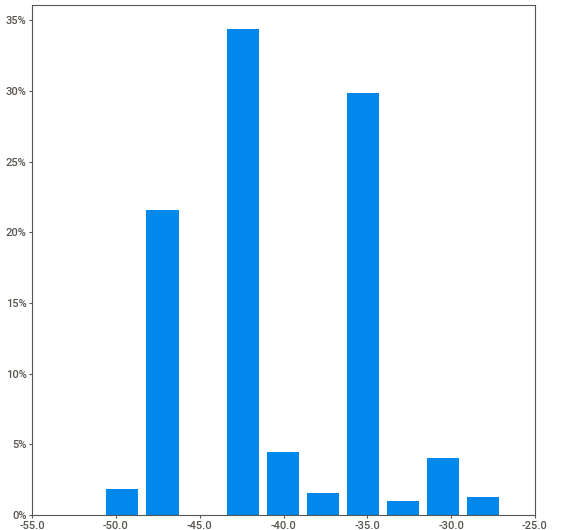
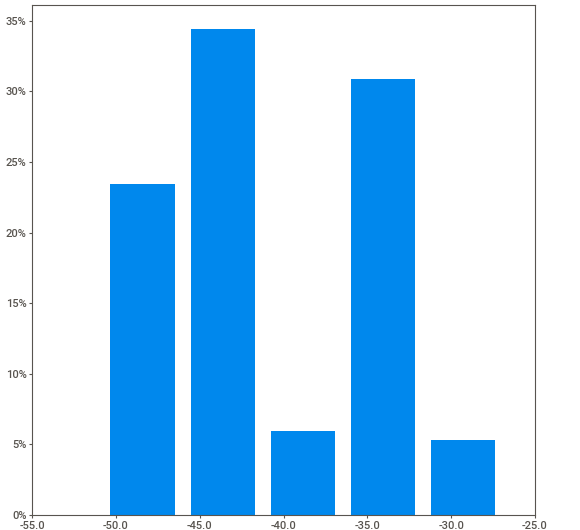
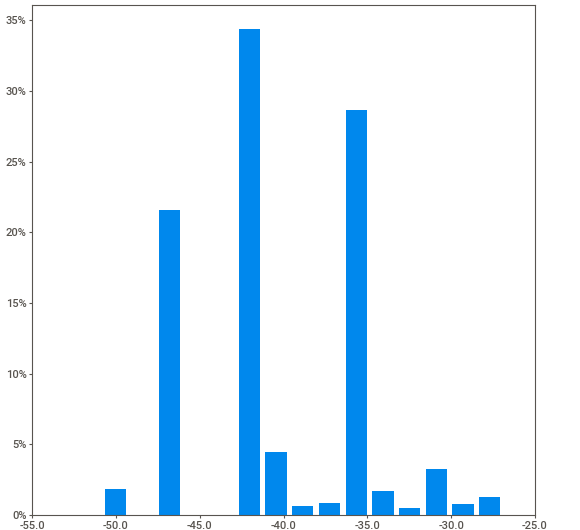
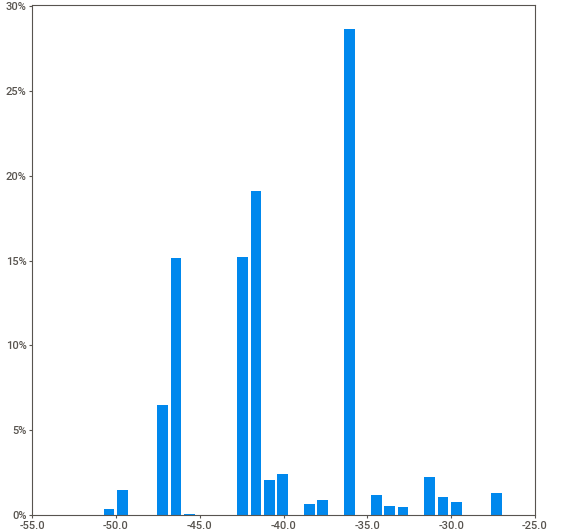
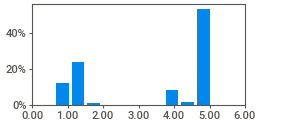
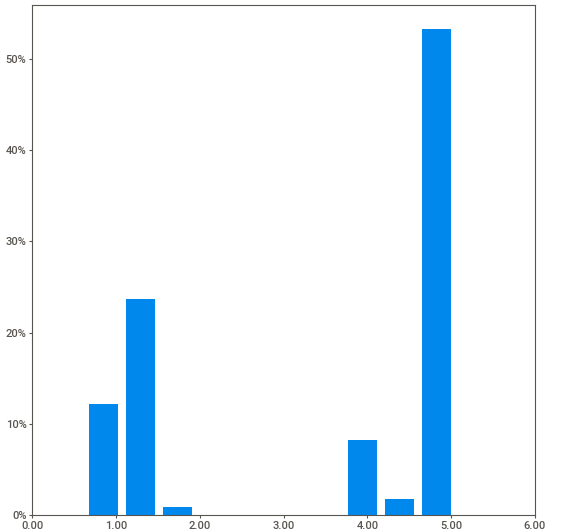
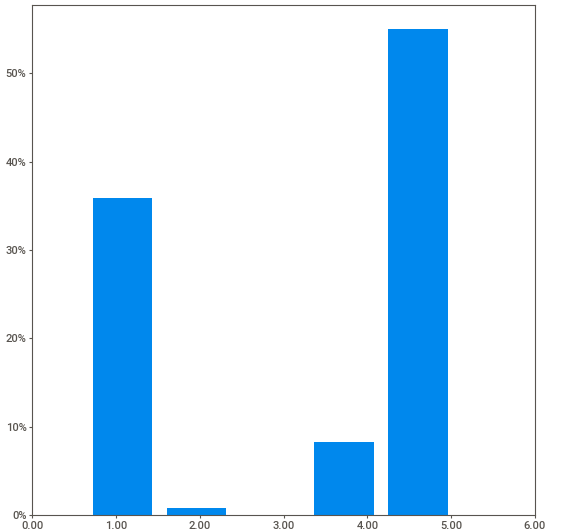
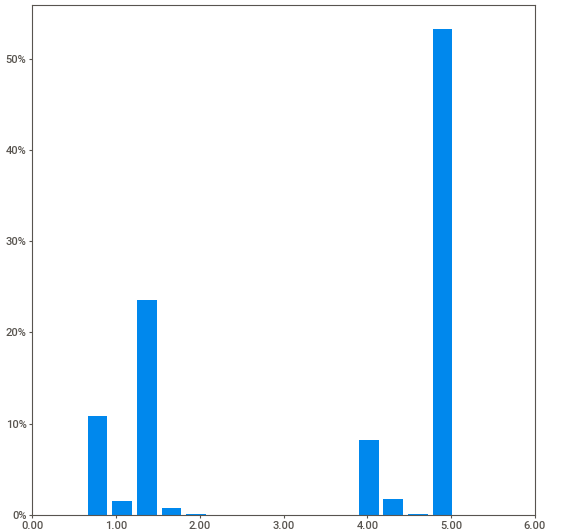
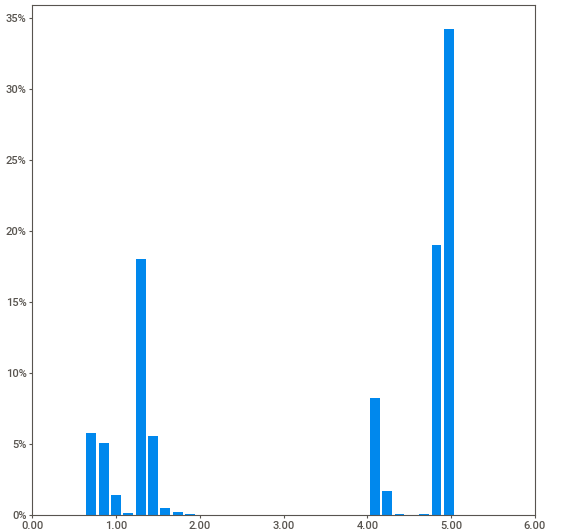
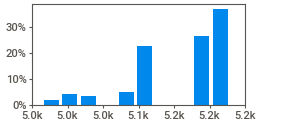
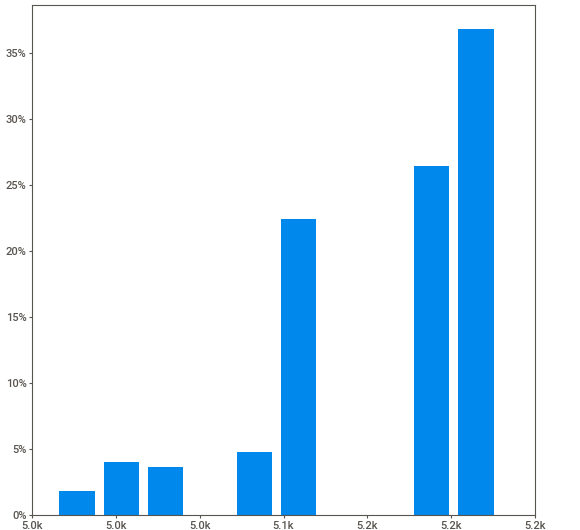
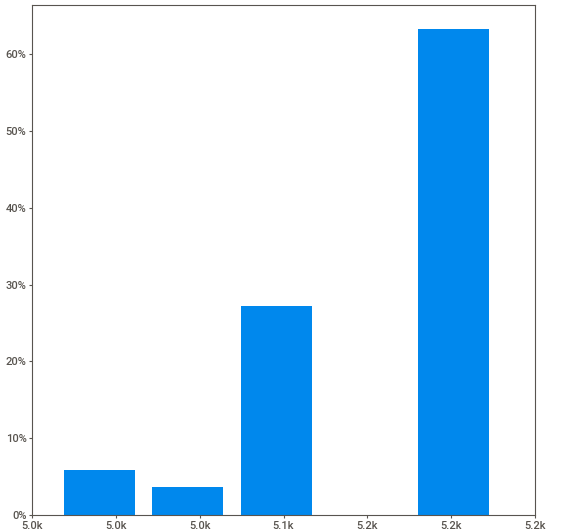
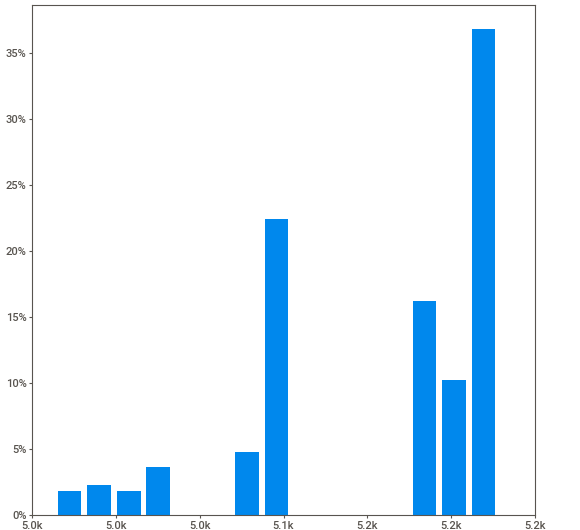
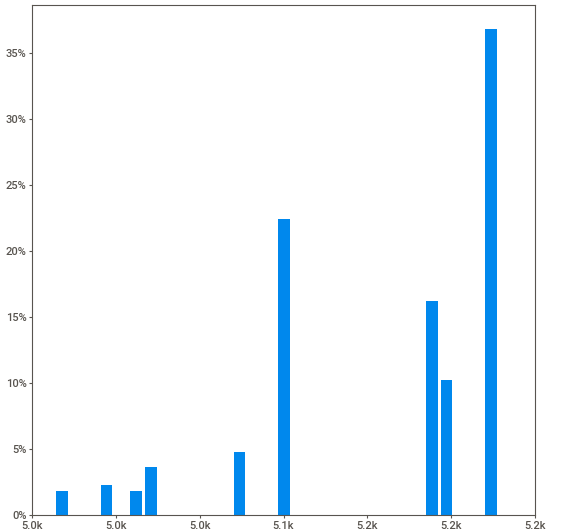
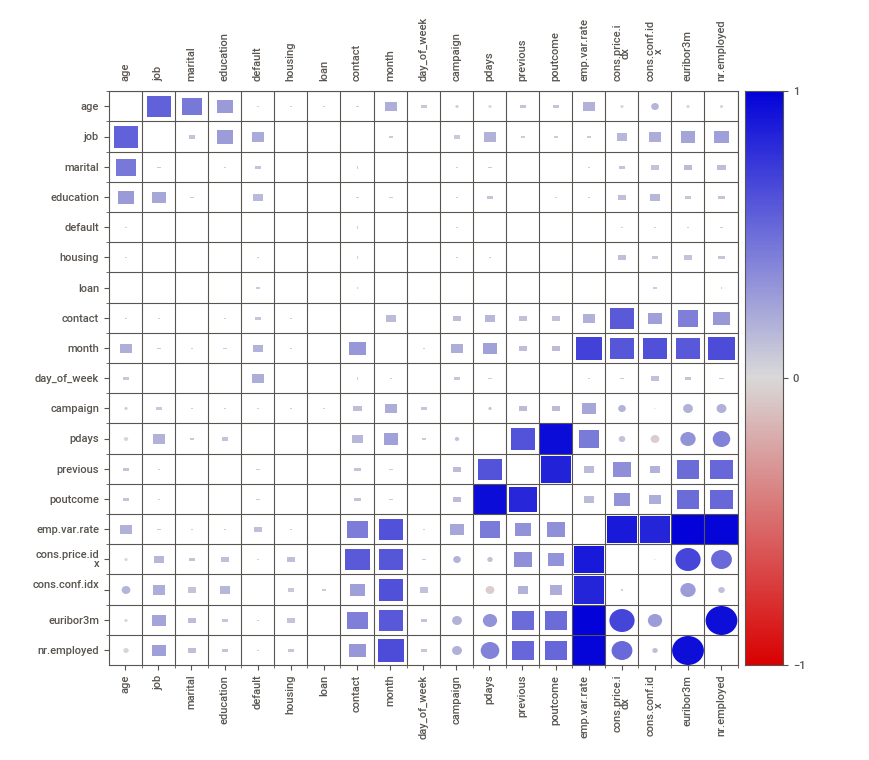
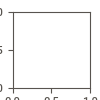

In [ ]:
# generate report
report = sv.analyze(data)
report.show_notebook()

Findings
  - we have no identifier besides the row number
  - there are duplicate values (*often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed*): we make a mental note, but make no amendments in the data
  - missing data: no explicit missing values, but
    - the description suggests that there are features for which the observation is `unknown` that would suggest implicit missing information. However, I did not find any occurences of `unknown` observation in case of neither categorical feature.
    - `Pdays`: number of days that passed by after the client was last
    contacted from a previous campaign (numeric; 999 means client was not
    previously contacted -> I will keep this encoding.
  - for marital status `divorced` actually means either divorced or widowed: we make a mental note, but make no amendments in the data

In [ ]:
# checking distinct values in categorical columns
{col: data[col].unique() for col in data.select_dtypes('object').columns}

{'contact': array(['telephone', 'cellular'], dtype=object),
 'day_of_week': array(['mon', 'tue', 'wed', 'thu', 'fri'], dtype=object),
 'default': array(['no', 'yes'], dtype=object),
 'education': array(['basic.4y', 'high.school', 'basic.6y', 'professional.course',
        'basic.9y', 'university.degree', 'illiterate'], dtype=object),
 'housing': array(['no', 'yes'], dtype=object),
 'job': array(['housemaid', 'services', 'admin.', 'technician', 'blue-collar',
        'unemployed', 'retired', 'entrepreneur', 'management', 'student',
        'self-employed'], dtype=object),
 'loan': array(['no', 'yes'], dtype=object),
 'marital': array(['married', 'single', 'divorced'], dtype=object),
 'month': array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr',
        'sep'], dtype=object),
 'poutcome': array(['nonexistent', 'failure', 'success'], dtype=object)}

In [ ]:
# double checking whether there are `unknown` observations
for col in data.select_dtypes('object').columns:
  if 'unknown' in [x.lower() for x in data[col].unique()]:
    print(col)

In [ ]:
# checking explicitely missing data
data.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
dtype: int64

In [ ]:
#size = data.groupby(data.columns.tolist(), as_index=False).size().rename({'size': 'num_contacts'}, axis=1)
#size
#data = pd.merge(left=data, right=size, on=data.columns.to_list(), how='left').copy()
#data[data.duplicated(keep=False)]

## Labeled example set

                                             |          | [  0%]   00:00 -> (? left)


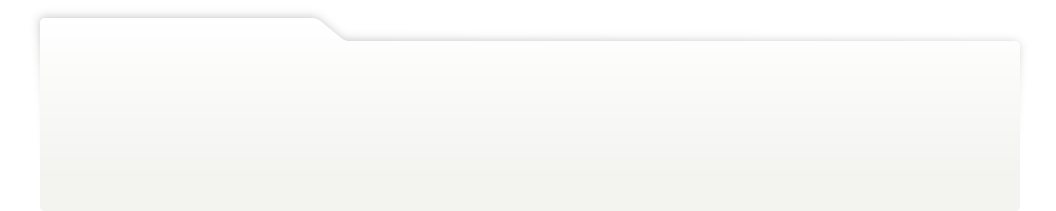
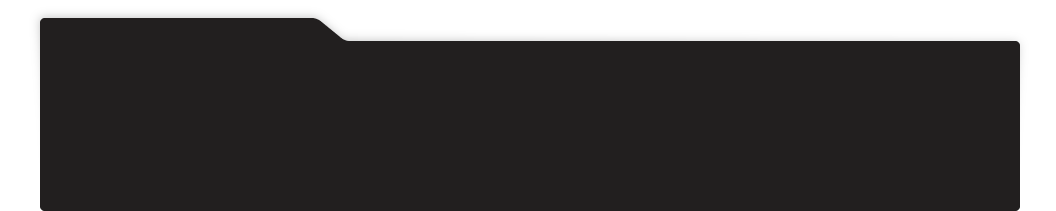
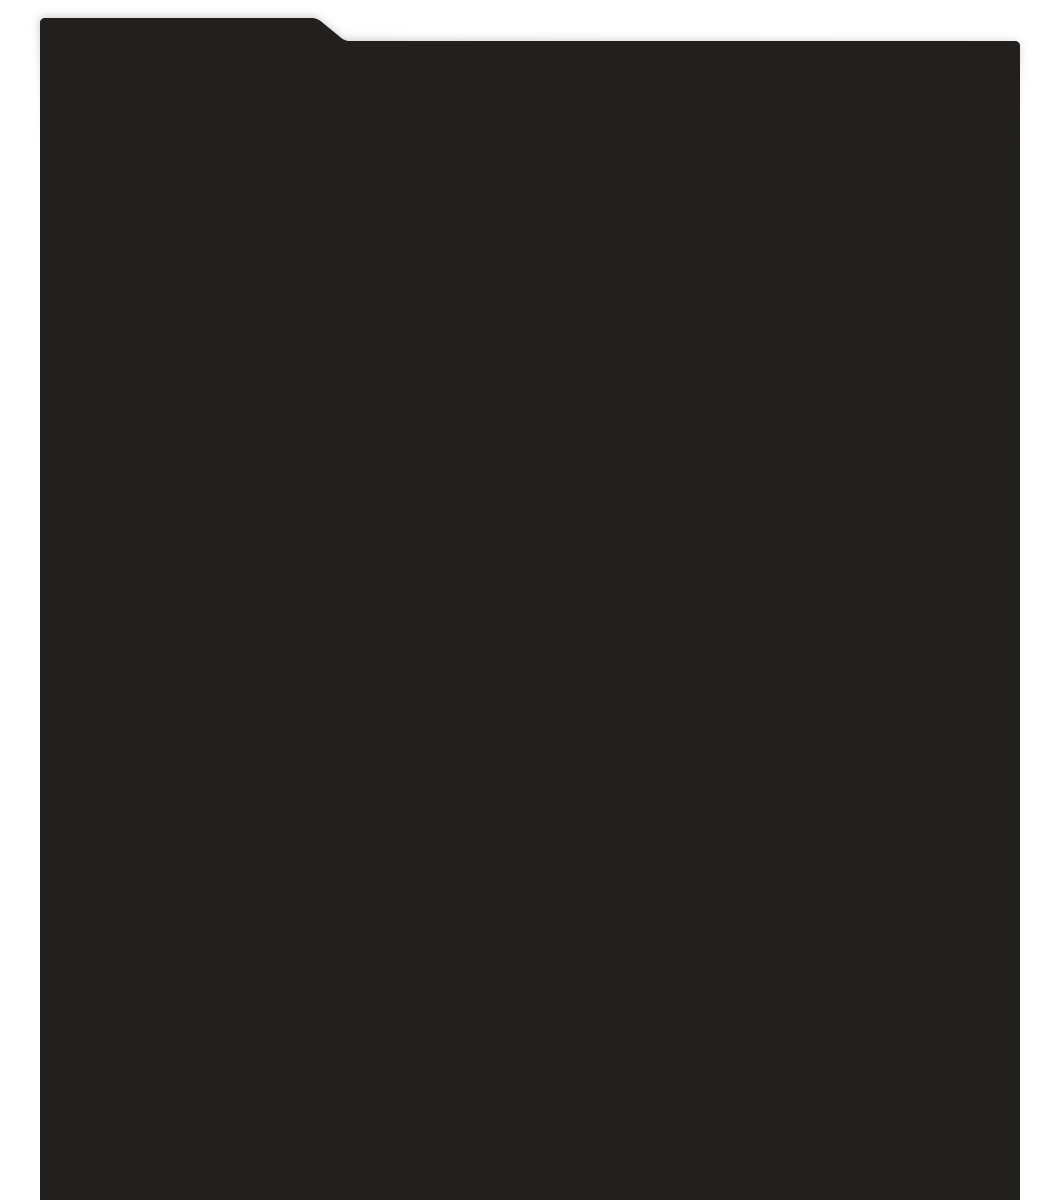
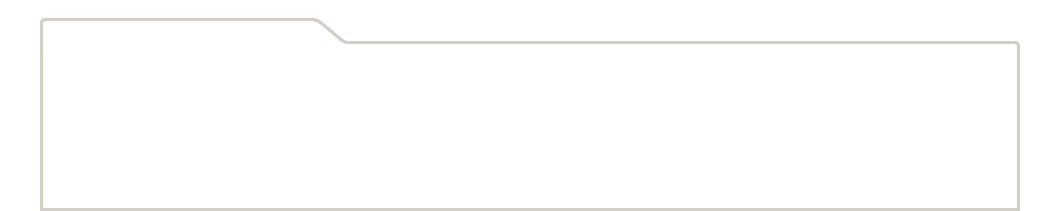
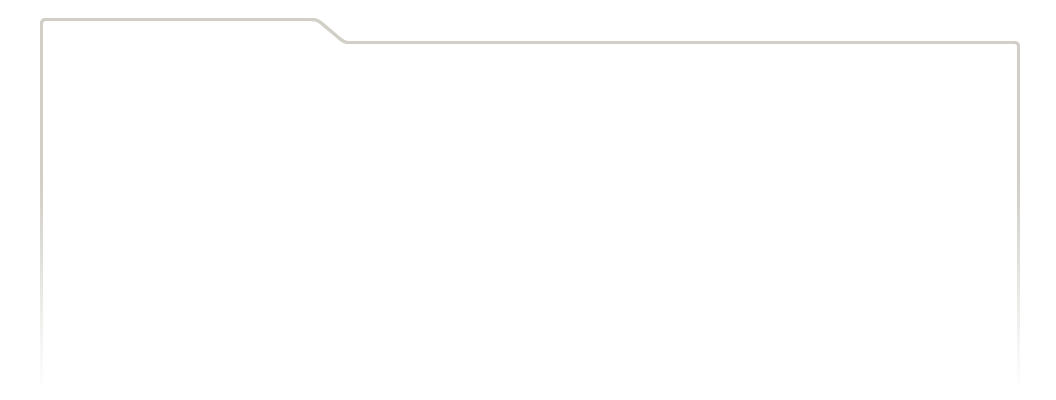
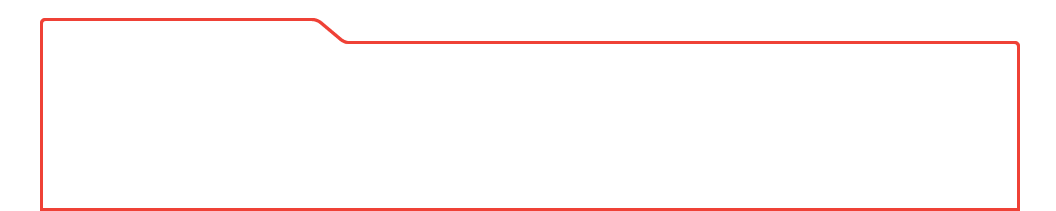
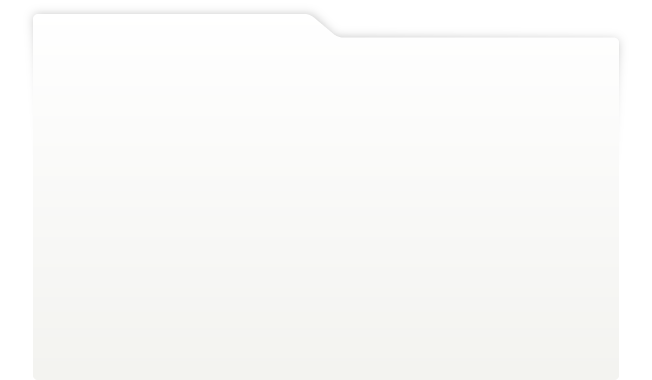
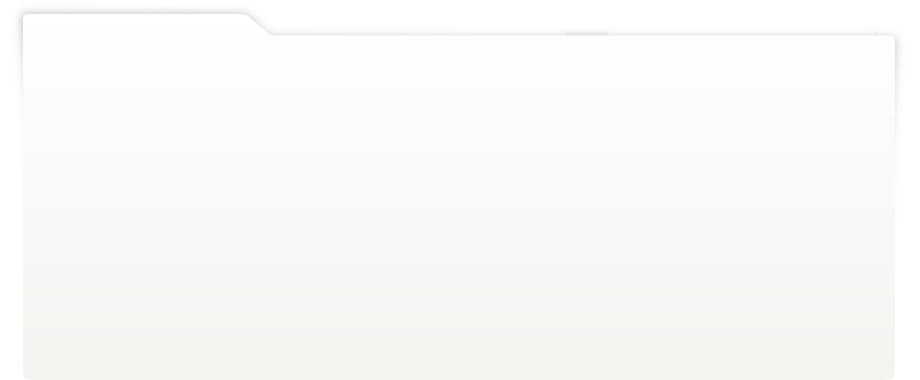
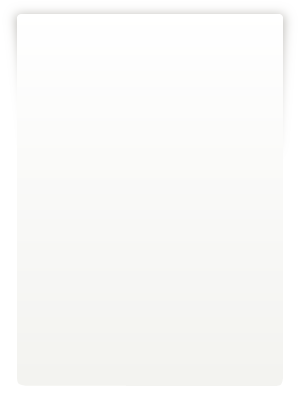
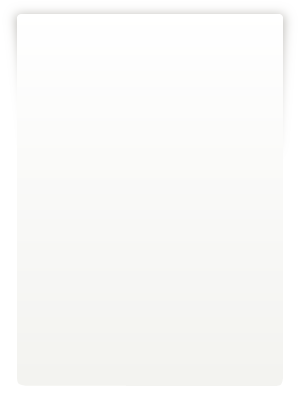
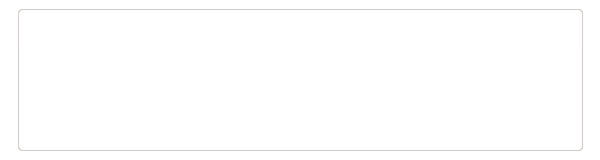
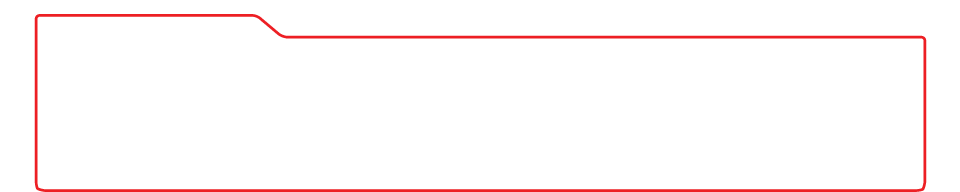
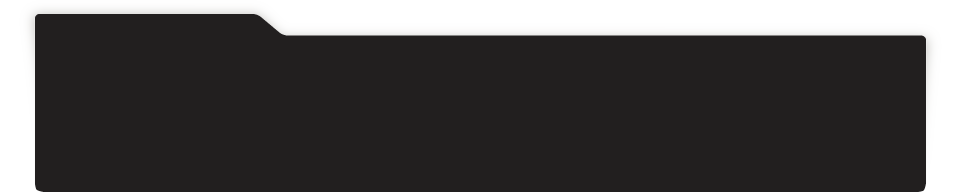
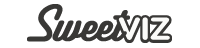
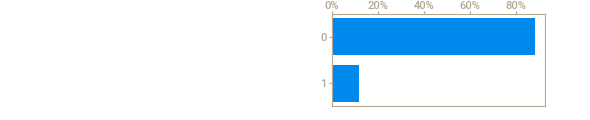
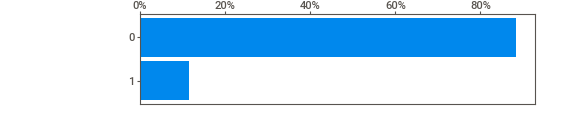
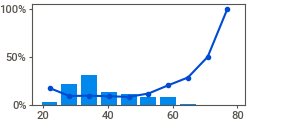
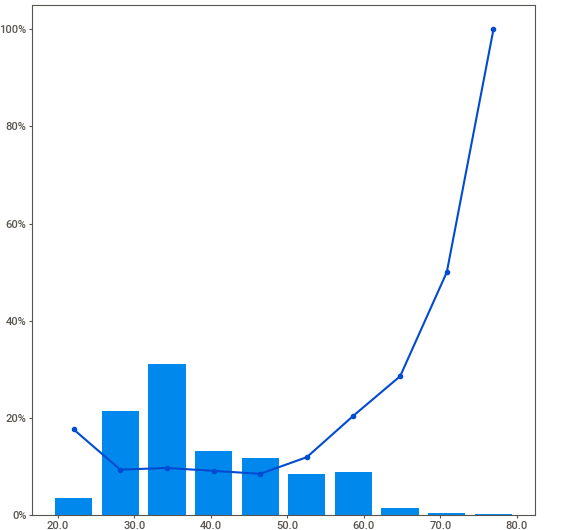
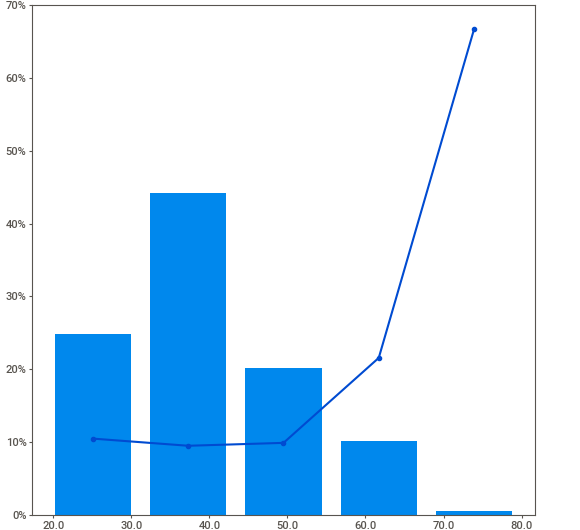
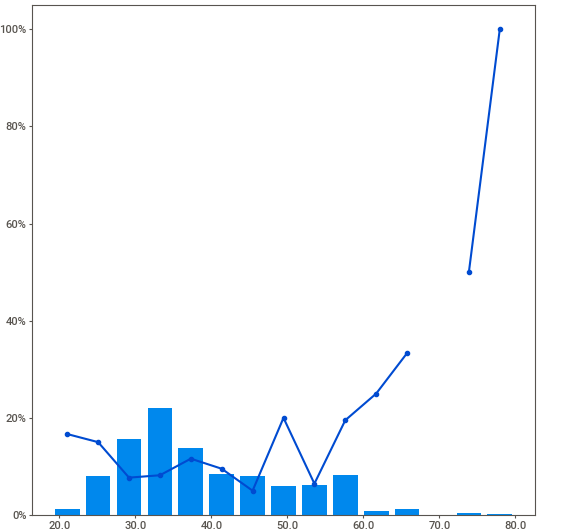
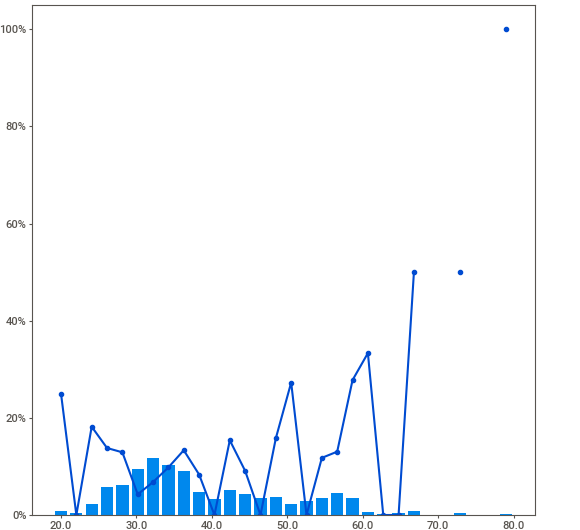
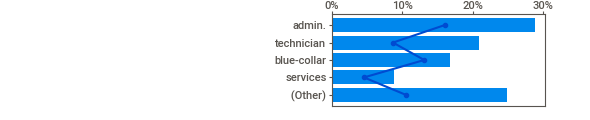
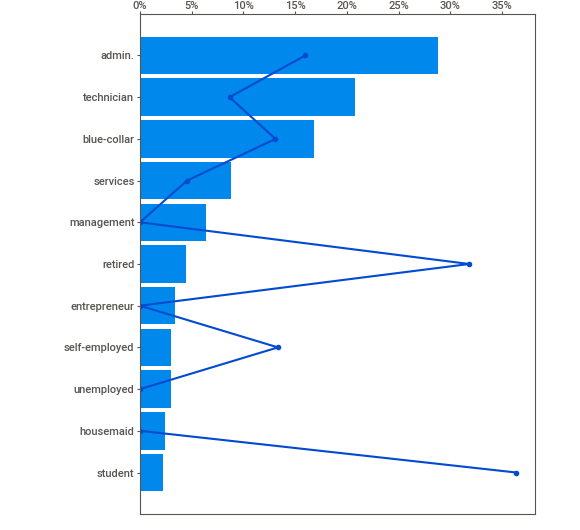
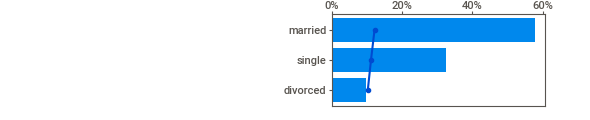
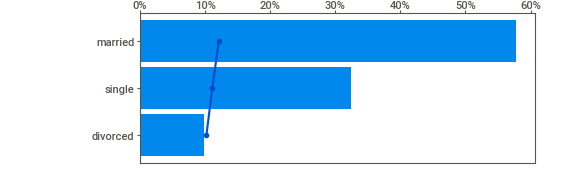
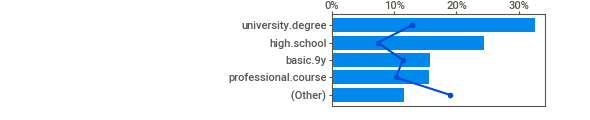
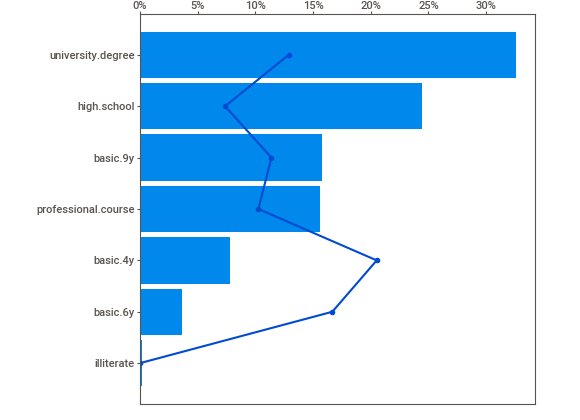
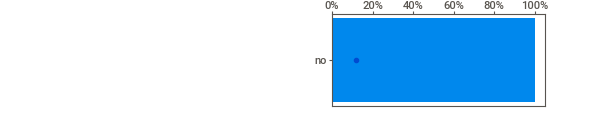
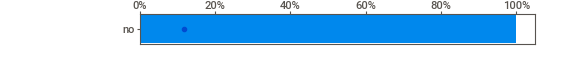
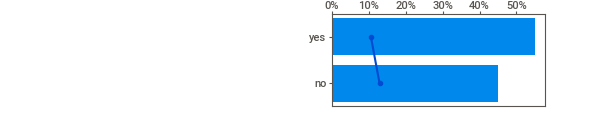
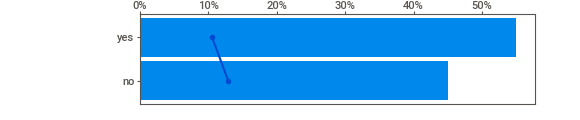
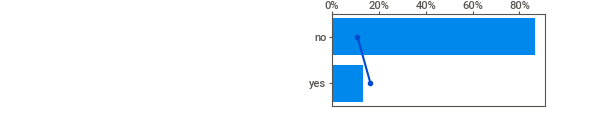
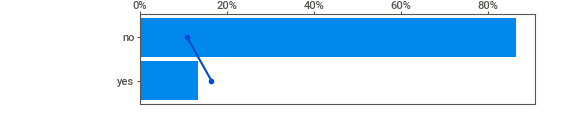
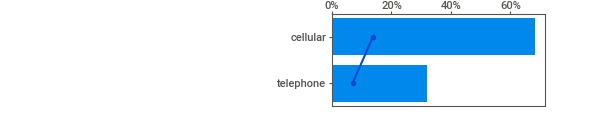
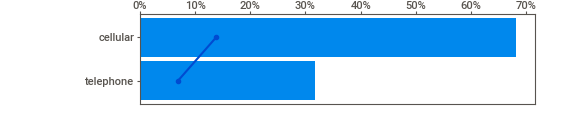
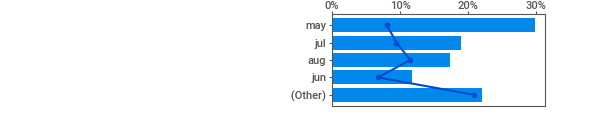
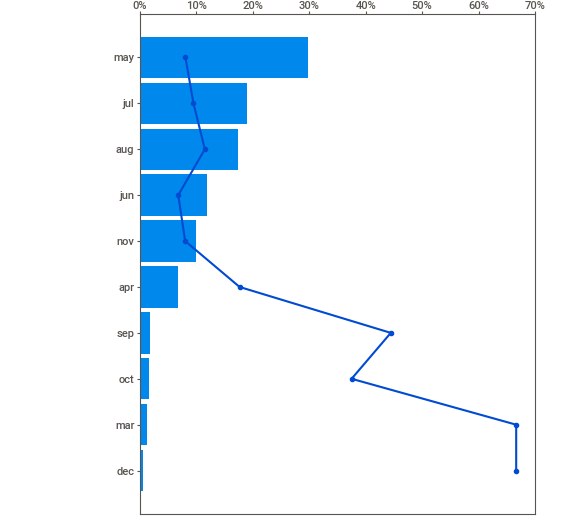
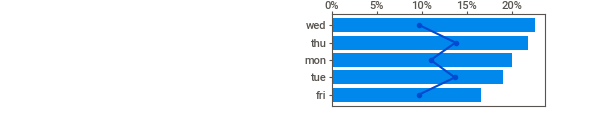
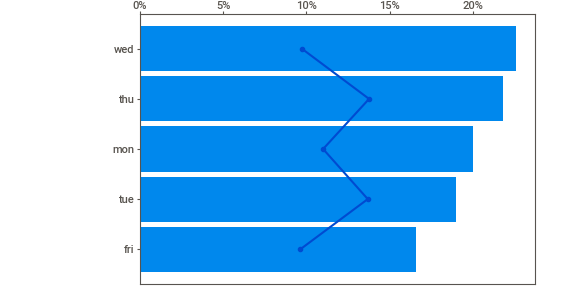
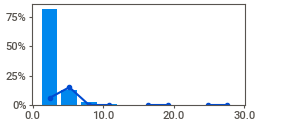
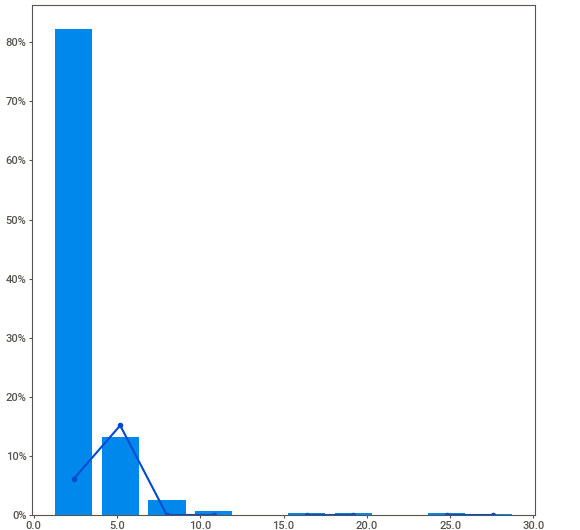
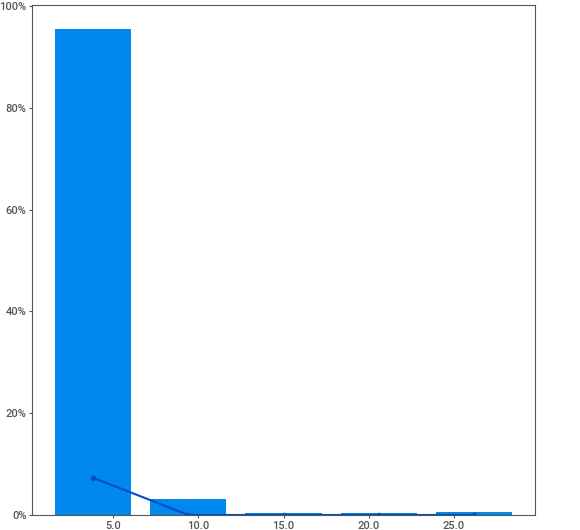
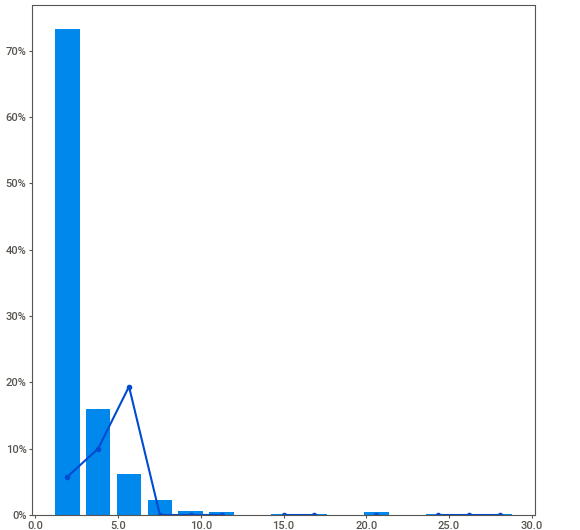
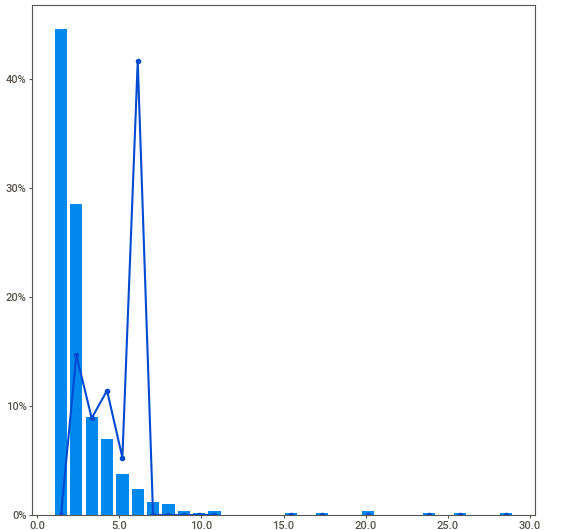
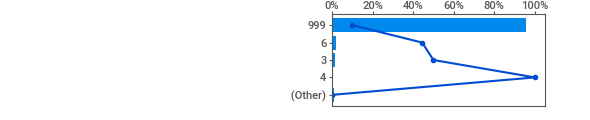
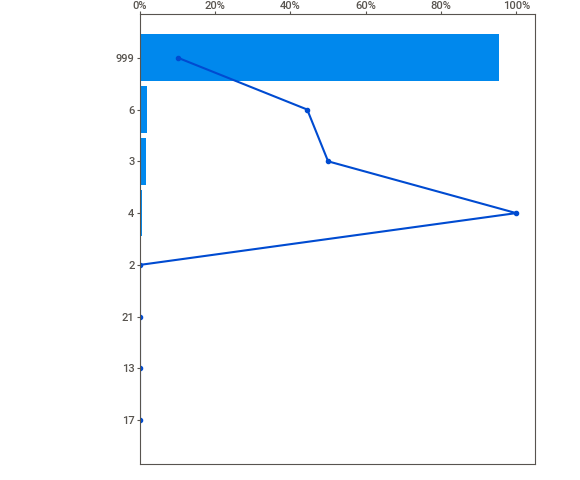
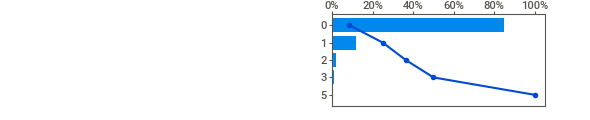
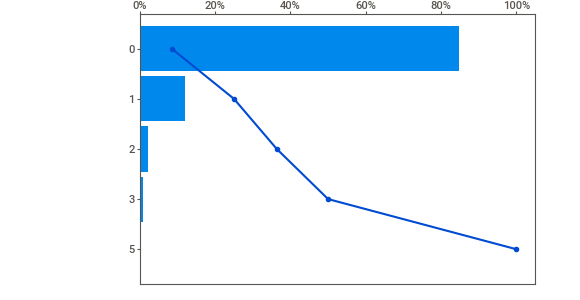
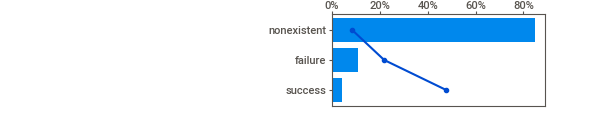
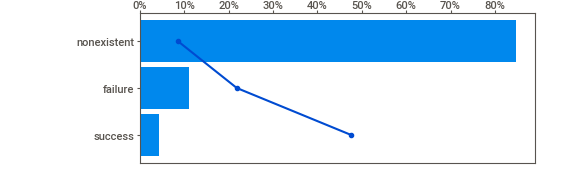
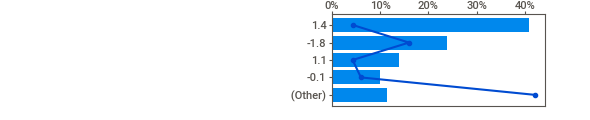
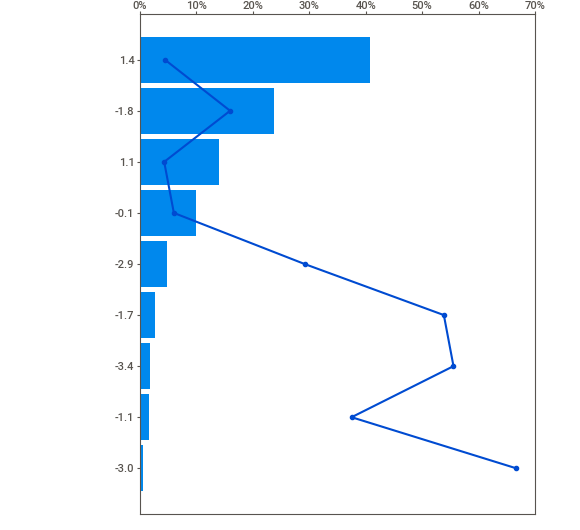
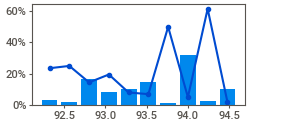
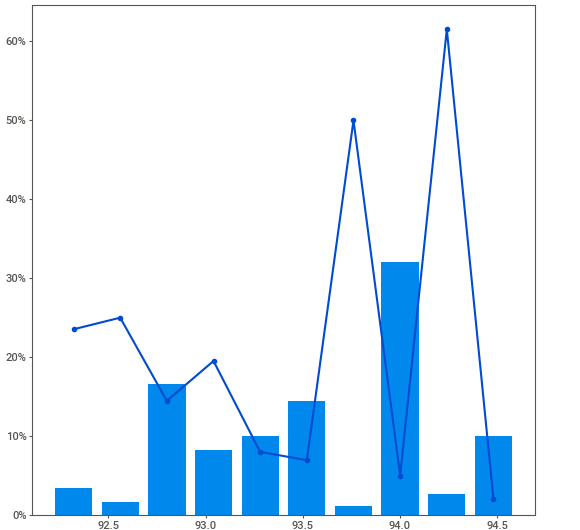
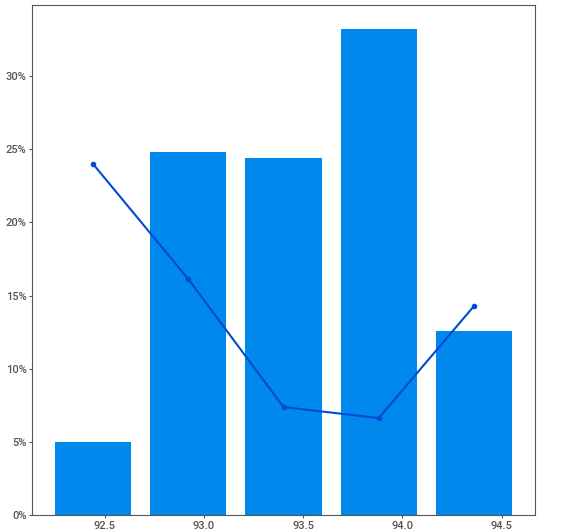
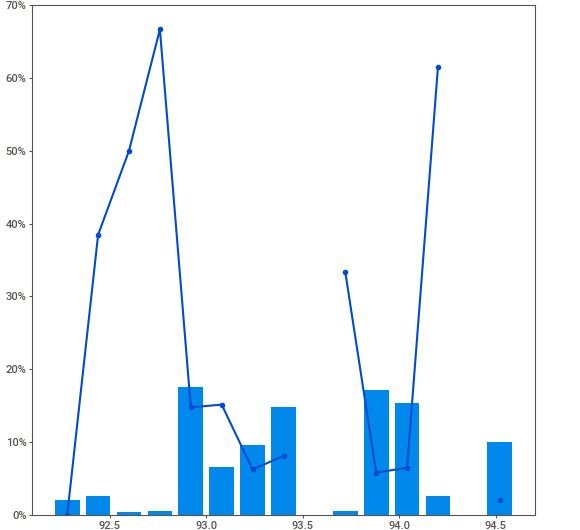
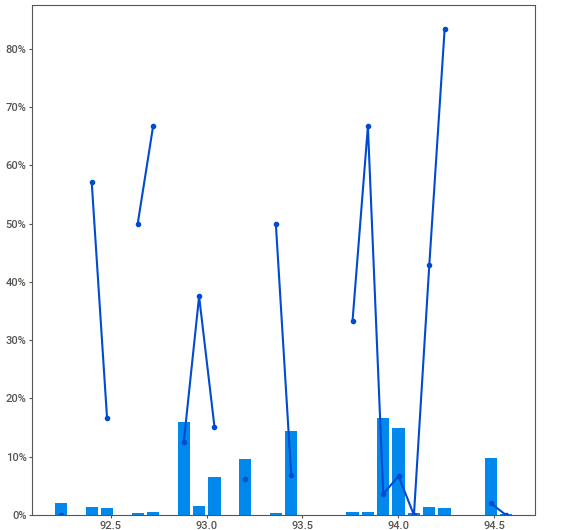
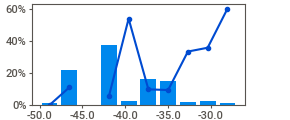
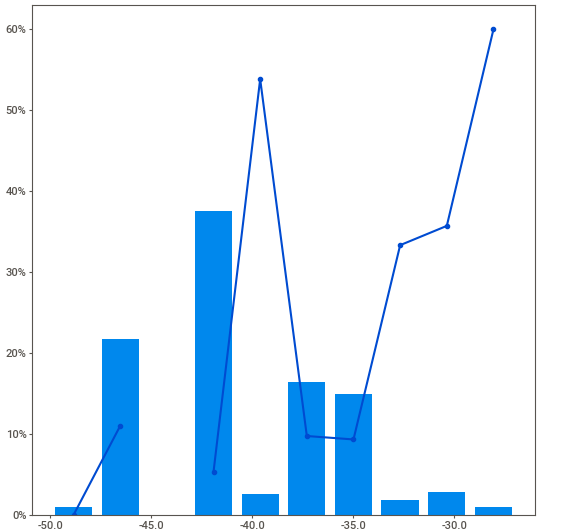
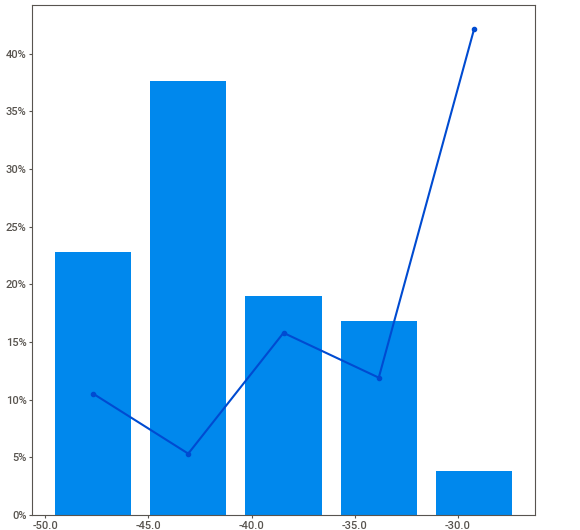
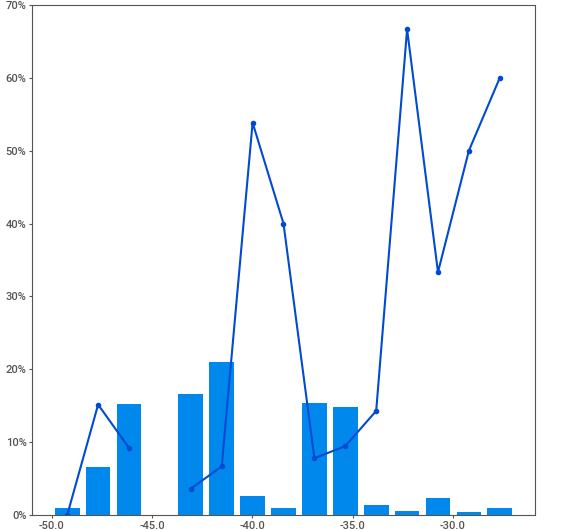
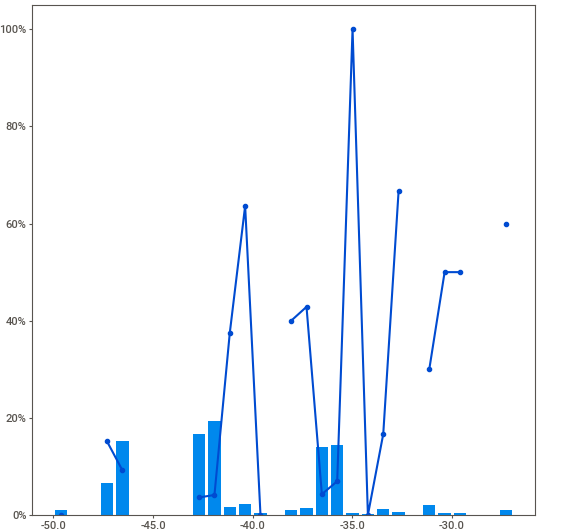
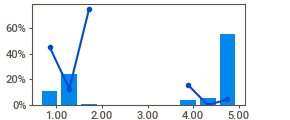
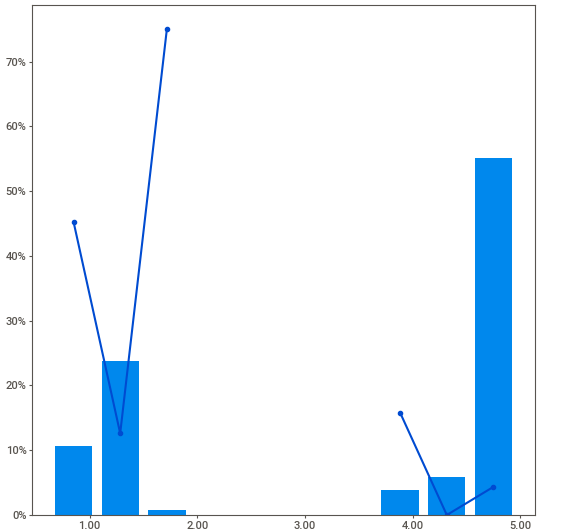
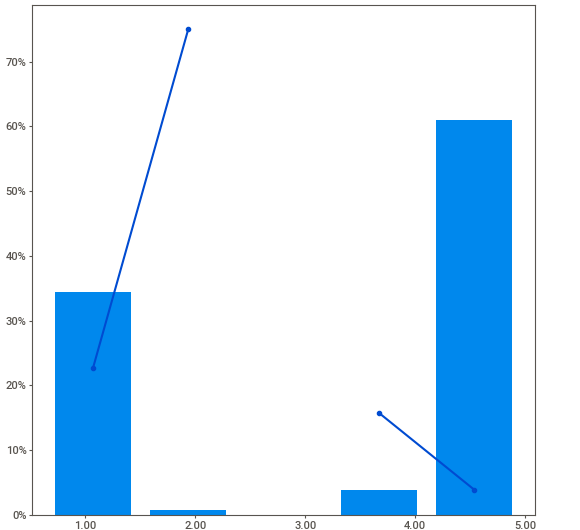
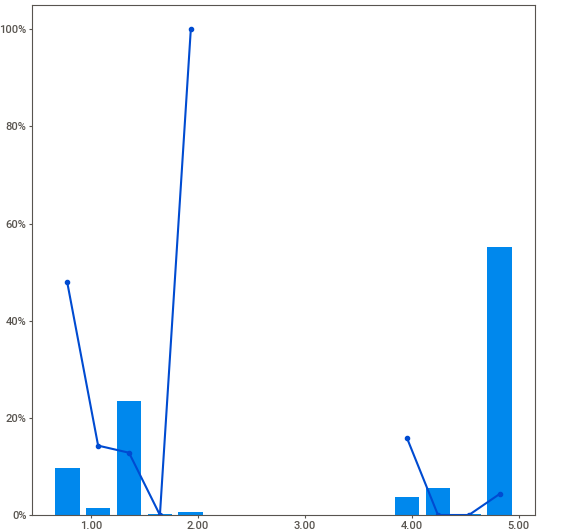
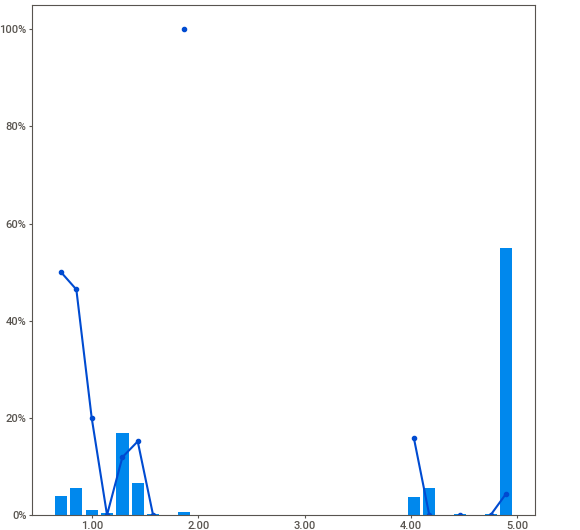
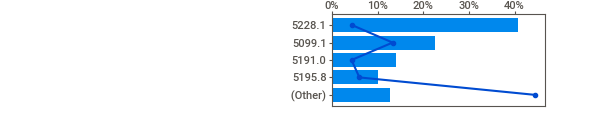
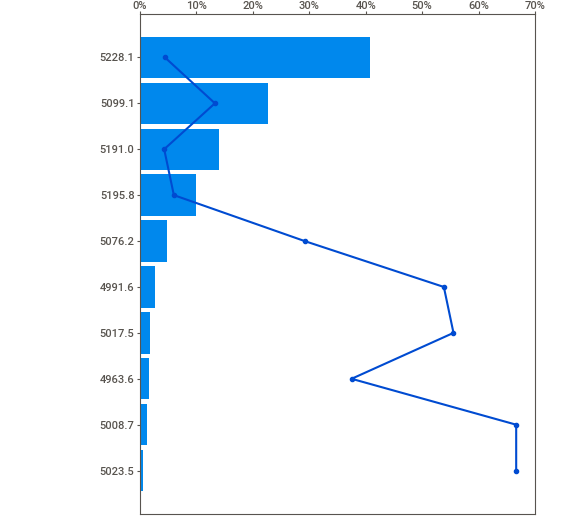
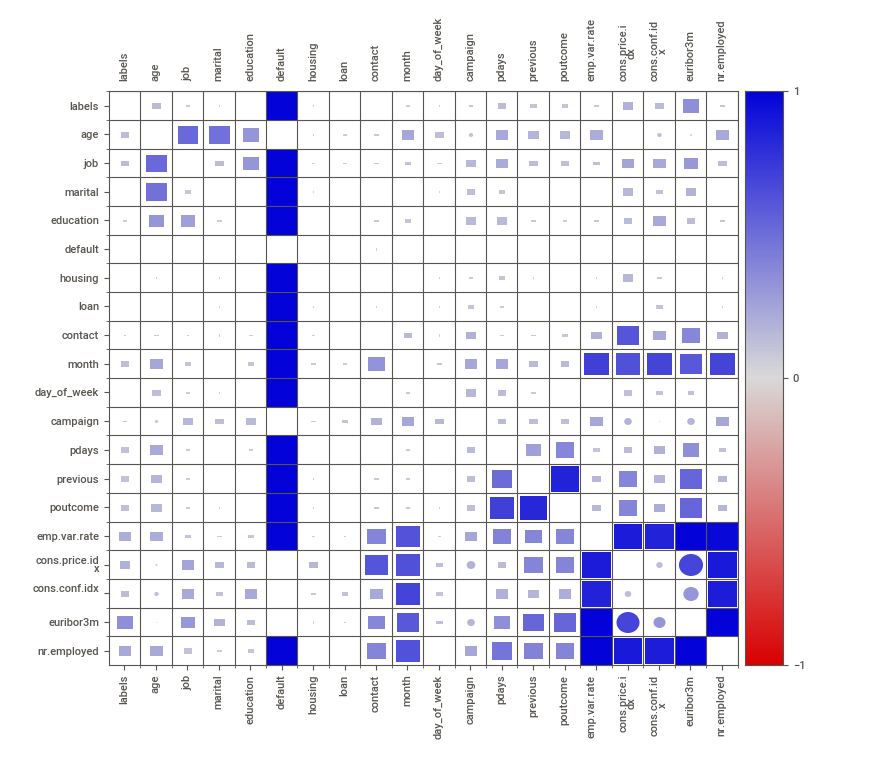
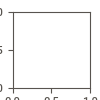

In [ ]:
# generate first report
report = sv.analyze(labels, 'labels')
#report.show_html('sweetviz_report_labels.html')
report.show_notebook()

In [ ]:
labels.labels.value_counts(normalize=True)

0    0.884
1    0.116
Name: labels, dtype: float64

In [ ]:
labels.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'labels'],
      dtype='object')

By analysing the above results I concluded the following:

- We were provided 500 labeled examples of which the telemarketing had about `11.6%` success rate.
- `age`: age bins between 20-60 have the most labeled observations and and have an even success rate and we can see an increase in the success rate above 60+years, although there are fewer observations in those bins
- `job`: students and retirees had higher success rates, the lowest scores correspond to managers, entrepreneurs and unemployed people, housemaids.
- `marital`: married people had higher success rates compared to others
- `education`: the highest success rates correspond to people with lower education
- `default`: all observations in the labeled set was `no`
- `housing`: people *without* housing had higher success rates
- `loan`: people *with* loans had higher success rates
- `contact`: cellular contacts had above average success rates, whereas telephone contact had below average. An intuitive explanation may be that people reached during working hours via cell phone may be in a rush and may decide more quickly without giving less though, where people reached via telephone are possible in a more calmer environment, have more time to think and refuse offers. 
- `month`: we can see a peak in success rates during march, december, september 
- `day_of_week`: we can see a day-by-day fluctuation: mon below average, tue above average, wed below average and so on (friday being the least successful)
- `campaign`: we can see a "sweet-spot" in the number of contacts performed during this campaign: more contacts increase the success rate with a peak at `6` and there is a significant decline starting from `7` (however, there are very few observations in those bins)
- `pdays`: `999` (i.e clients not contacted in previous campaigns has average success rates, and if there was a previous contact the success rates tends to be higher
- `previous`: generally by the increase in the number of contacts we observe an increase in success rates
- `poutcome`: `success` in previous campaigns indicate higher success rates in current campagins, interestingly, failure in previous campaigns has above average success rates in this campaign
- `emp.var.rate`: lower (below zero) values had higher success rates
- `cons.price.idx`: we observed the highest success rate for the lowest consumer price index observations
- `cons.conf.idx`: highest values (the scale is negative, so values closest to zero) had the highest success rates
- `euribor3m`: most frequent observations had around average success rates, all other seem to be outlier
- `nr.employed`:

# Data preperation

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30488 entries, 0 to 30487
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30488 non-null  int64  
 1   job             30488 non-null  object 
 2   marital         30488 non-null  object 
 3   education       30488 non-null  object 
 4   default         30488 non-null  object 
 5   housing         30488 non-null  object 
 6   loan            30488 non-null  object 
 7   contact         30488 non-null  object 
 8   month           30488 non-null  object 
 9   day_of_week     30488 non-null  object 
 10  campaign        30488 non-null  int64  
 11  pdays           30488 non-null  int64  
 12  previous        30488 non-null  int64  
 13  poutcome        30488 non-null  object 
 14  emp.var.rate    30488 non-null  float64
 15  cons.price.idx  30488 non-null  float64
 16  cons.conf.idx   30488 non-null  float64
 17  euribor3m       30488 non-null 

## Categorical features - LabelEncoder

In [ ]:
for col in data.select_dtypes('object').columns:
  le = LabelEncoder()
  data[col] = le.fit_transform(data[col])

In [ ]:
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,3,1,0,0,0,0,1,6,1,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0
1,37,7,1,3,0,1,0,1,6,1,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0
2,40,0,1,1,0,0,0,1,6,1,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0
3,56,7,1,3,0,0,1,1,6,1,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0
4,59,0,1,5,0,0,0,1,6,1,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,73,5,1,5,0,1,0,0,7,0,1,999,0,1,-1.1,94.767,-50.8,1.028,4963.6
30484,46,1,1,5,0,0,0,0,7,0,1,999,0,1,-1.1,94.767,-50.8,1.028,4963.6
30485,56,5,1,6,0,1,0,0,7,0,2,999,0,1,-1.1,94.767,-50.8,1.028,4963.6
30486,44,9,1,5,0,0,0,0,7,0,1,999,0,1,-1.1,94.767,-50.8,1.028,4963.6


## Numerical features - standardization

In [ ]:
scaler = StandardScaler()
data.loc[:, data.select_dtypes(include=float).columns] = scaler.fit_transform(data.select_dtypes(include=float))

In [ ]:
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,3,1,0,0,0,0,1,6,1,1,999,0,1,0.727477,0.804095,0.877451,0.786102,0.401648
1,37,7,1,3,0,1,0,1,6,1,1,999,0,1,0.727477,0.804095,0.877451,0.786102,0.401648
2,40,0,1,1,0,0,0,1,6,1,1,999,0,1,0.727477,0.804095,0.877451,0.786102,0.401648
3,56,7,1,3,0,0,1,1,6,1,1,999,0,1,0.727477,0.804095,0.877451,0.786102,0.401648
4,59,0,1,5,0,0,0,1,6,1,1,999,0,1,0.727477,0.804095,0.877451,0.786102,0.401648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,73,5,1,5,0,1,0,0,7,0,1,999,0,1,-0.638666,2.124640,-2.129332,-1.368408,-2.624025
30484,46,1,1,5,0,0,0,0,7,0,1,999,0,1,-0.638666,2.124640,-2.129332,-1.368408,-2.624025
30485,56,5,1,6,0,1,0,0,7,0,2,999,0,1,-0.638666,2.124640,-2.129332,-1.368408,-2.624025
30486,44,9,1,5,0,0,0,0,7,0,1,999,0,1,-0.638666,2.124640,-2.129332,-1.368408,-2.624025


# Baseline models

## K-means clustering

First let's apply k-means clustering with `n_clusters=2` and see how this performs on the evaluation labels.

In [ ]:
# fitting
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_kmeans = kmeans.fit_predict(data.values)

# evaluating
col = f'kmeans={n_clusters}'
y = pd.DataFrame({col: y_kmeans})

df = pd.merge(left=labels, right=y, left_index=True, right_index=True, how='left')
print(f'Balanced accuracy for {col}:',
      balanced_accuracy_score(y_true=df['labels'], y_pred=df[col]),
      '\n\n', y.value_counts(normalize=True))

Balanced accuracy for kmeans=2: 0.571501014198783 

 kmeans=2
0           0.957032
1           0.042968
dtype: float64


Then we will use the elbow method to find the best number of clusters.

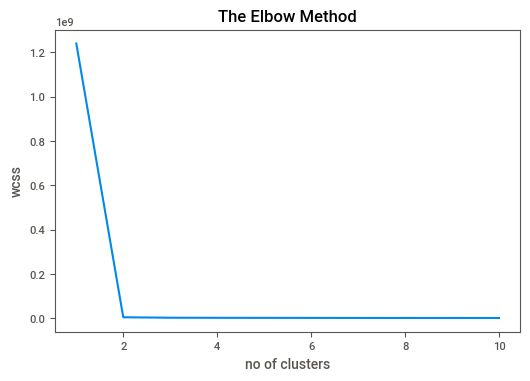

In [ ]:
# Elbow Method
score = [KMeans(n_clusters=k, init="k-means++", random_state=42).fit(data).inertia_ for k in range(1, 11)]

# plotting the score
plt.plot(range(1,11), score)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

Based on the elbow method the ideal number of clusters is 2.

## Isolation forest

In [ ]:
# fitting
clf = IsolationForest(random_state=42)
clf.fit(data)
y_isoforest = clf.predict(data)

# evaluating
col = 'isoforest'
y = pd.DataFrame({col: (y_isoforest == -1).astype(int)})
                                              
df = pd.merge(left=labels, right=y, left_index=True, right_index=True, how='left')
print(f'Balanced accuracy for {col}:',
      balanced_accuracy_score(y_true=df['labels'], y_pred=df[col]),
      '\n\n', y.value_counts(normalize=True))

Balanced accuracy for isoforest: 0.67842097051022 

 isoforest
0            0.678726
1            0.321274
dtype: float64


## One-class SVM

In [ ]:
# fitting
clf = OneClassSVM()
clf.fit(data)
y_svm = clf.predict(data)

# evaluating
col = 'oneclass-svm'
y = pd.DataFrame({col: (y_svm == -1).astype(int)})


df = pd.merge(left=labels, right=y, left_index=True, right_index=True, how='left')
print(f'Balanced accuracy for {col}:',
      balanced_accuracy_score(y_true=df['labels'], y_pred=df[col]),
      '\n\n', y.value_counts(normalize=True))

Balanced accuracy for oneclass-svm: 0.604579497581526 

 oneclass-svm
0               0.5
1               0.5
dtype: float64


## Local outlier factor

In [ ]:
# fitting
clf = LocalOutlierFactor()
y_lof = clf.fit_predict(data)

# evaluating
col = 'lof'
y = pd.DataFrame({col: (y_lof == -1).astype(int)})

df = pd.merge(left=labels, right=y, left_index=True, right_index=True, how='left')
print(f'Balanced accuracy for {col}:',
      balanced_accuracy_score(y_true=df['labels'], y_pred=df[col]),
      '\n\n', y.value_counts(normalize=True))

Balanced accuracy for lof: 0.5086206896551724 

 lof
0      0.99695
1      0.00305
dtype: float64


## Isolation forest on top of other models

In [ ]:
data_mod = pd.concat([data, pd.DataFrame({'kmeans': y_kmeans, 'svm': (y_svm == 1).astype(int) , 'lof': (y_lof == 1).astype(int)})], axis=1)
data_mod.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,kmeans,svm,lof
0,56,3,1,0,0,0,0,1,6,1,...,0,1,0.727477,0.804095,0.877451,0.786102,0.401648,0,0,1
1,37,7,1,3,0,1,0,1,6,1,...,0,1,0.727477,0.804095,0.877451,0.786102,0.401648,0,1,1
2,40,0,1,1,0,0,0,1,6,1,...,0,1,0.727477,0.804095,0.877451,0.786102,0.401648,0,1,1
3,56,7,1,3,0,0,1,1,6,1,...,0,1,0.727477,0.804095,0.877451,0.786102,0.401648,0,0,1
4,59,0,1,5,0,0,0,1,6,1,...,0,1,0.727477,0.804095,0.877451,0.786102,0.401648,0,0,1


In [ ]:
# fitting
clf = IsolationForest(random_state=42)
clf.fit(data_mod)
y_isoforest = clf.predict(data_mod)

# evaluating
col = 'isoforest'
y = pd.DataFrame({col: (y_isoforest == -1).astype(int)})

df = pd.merge(left=labels, right=y, left_index=True, right_index=True, how='left')
print(f'Balanced accuracy for {col}:',
      balanced_accuracy_score(y_true=df['labels'], y_pred=df[col]),
      '\n\n', y.value_counts(normalize=True))

Balanced accuracy for isoforest: 0.6953892963020751 

 isoforest
0            0.709131
1            0.290869
dtype: float64


# Isolation forest, but playing with the contamination

In [ ]:
# fitting
clf = IsolationForest(random_state=42, contamination=0.116) # 11.6% success rate comes from the provided labeled observations
clf.fit(data_mod.to_numpy())
y_isoforest_cont = clf.predict(data_mod.to_numpy())

# evaluating
col = 'isoforest'
y = pd.DataFrame({col: (y_isoforest_cont == -1).astype(int)})

df = pd.merge(left=labels, right=y, left_index=True, right_index=True, how='left')
print(f'Balanced accuracy for {col}:',
      balanced_accuracy_score(y_true=df['labels'], y_pred=df[col]),
      '\n\n', y.value_counts(normalize=True))

Balanced accuracy for isoforest: 0.6219378998283663 

 isoforest
0            0.883987
1            0.116013
dtype: float64


# Submissions

Your submissions *must have* the same format as comp_5_sample_submission.csv (containing either a 'yes' or 'no' in each column, in the order the dataset is originally given, without row numbers or headers), and it must have your name in the filename.


In [ ]:
def save_submission(filepath: str, y: np.array):
  df = pd.DataFrame(y).replace({0: 'no', 1: 'yes'})
  df.to_csv(filepath, index=False, header=None)

In [ ]:
submission_title = '01-isoforest'
save_submission(f'dm_competition5_Balázs_Nagy_{submission_title}.csv', (y_isoforest == -1).astype(int))

In [ ]:
submission_title = '02-oneclasssvm'
save_submission(f'dm_competition5_Balázs_Nagy_{submission_title}.csv', (y_svm == -1).astype(int))

In [ ]:
submission_title = '03-lof'
save_submission(f'dm_competition5_Balázs_Nagy_{submission_title}.csv', (y_lof == -1).astype(int))